# Restore Ecosystems

This notebook outlines the general workflow for the data within the Restore Ecosystems wedge of the Ocean Central website.

Unless otherwise noted, all polygonal calculations were done in the Mollweide Projection (ESRI:54009)

In [ ]:
# Utils functions used throughout the notebook across sections

import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

import pandas as pd
import json
import os
import re
import math
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np


# Obtain the vector extent overlaying a raster
def raster_vector_intersection_stats(
    raster_path: str,
    vector_path: str,
    vector_layer: str | None = None,
    out_raster_union: str | None = "raster_gt0_union.geojson",
    out_intersection: str | None = "raster_vector_intersection.geojson",
    area_crs: str = "ESRI:54009",
):
    """
    Compute intersection between a raster mask (values > 0) and a vector layer,
    and print areas + percentage.

    Parameters
    ----------
    raster_path : str
        Path to the raster file.
    vector_path : str
        Path to the vector file (e.g. shapefile, GeoPackage, GeoJSON).
    vector_layer : str or None, optional
        Layer name for multi-layer formats (e.g. GeoPackage). If None,
        uses the default layer for the file.
    out_raster_union : str or None, optional
        Output path for the union of raster>0 polygons (GeoJSON). If None, not saved.
    out_intersection : str or None, optional
        Output path for the intersection polygons (GeoJSON). If None, not saved.
    area_crs : str, optional
        Equal-area CRS used to compute areas (default: ESRI:54009, Mollweide).

    Returns
    -------
    result : geopandas.GeoDataFrame
        Intersection GeoDataFrame.
    stats : dict
        Dictionary with 'raster_area', 'vector_area', 'percentage'.
    """

    # -------------------------------------------------------------------
    # 1. Read polygons
    # -------------------------------------------------------------------
    if vector_layer:
        poly_gdf = gpd.read_file(vector_path, layer=vector_layer)
    else:
        poly_gdf = gpd.read_file(vector_path)
    print("Polygons read")

    # -------------------------------------------------------------------
    # 2. Build polygons from raster cells where raster > 0
    # -------------------------------------------------------------------
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata
        raster_crs = src.crs

        # mask = True where raster value > 0
        mask = data > 0
        if nodata is not None:
            mask &= (data != nodata)

        # Extract raster>0 regions as polygons
        raster_geoms = []
        for geom, val in shapes(data, mask=mask, transform=transform):
            # val is the raster value; we only care about geometry
            raster_geoms.append(shape(geom))

    print("Raster polygons created")

    # Merge all raster>0 polygons into one
    raster_union = gpd.GeoSeries(raster_geoms, crs=raster_crs).unary_union
    raster_union_gdf = gpd.GeoDataFrame(geometry=[raster_union], crs=raster_crs)

    # Optional: save union polygon
    if out_raster_union is not None:
        raster_union_gdf.to_file(out_raster_union, driver="GeoJSON")
        print(f"Saved raster>0 union to {out_raster_union}")

    # -------------------------------------------------------------------
    # 3. Reproject polygons if needed
    # -------------------------------------------------------------------
    if poly_gdf.crs != raster_union_gdf.crs:
        poly_gdf = poly_gdf.to_crs(raster_union_gdf.crs)
        print(f"Reprojected vectors to {raster_union_gdf.crs}")

    # -------------------------------------------------------------------
    # 4. Intersect polygons with raster>0 area
    # -------------------------------------------------------------------
    result = gpd.overlay(poly_gdf, raster_union_gdf, how="intersection")

    # Save intersection (optional)
    if out_intersection is not None:
        result.to_file(out_intersection, driver="GPKG")
        print(f"Saved intersection to {out_intersection}")

    print(result.head())

    # -------------------------------------------------------------------
    # 5. Area calculations in Mollewide CRS
    # -------------------------------------------------------------------
    # Dissolve vectors into one polygon and compute area in equal-area CRS
    vector_diss = poly_gdf.dissolve()
    vector_diss_moll = vector_diss.to_crs(area_crs)
    vector_area = vector_diss_moll.geometry.area.iloc[0]

    # Dissolve intersection polygons into one and compute area in equal-area CRS
    inter_diss = result.dissolve()
    inter_diss_moll = inter_diss.to_crs(area_crs)
    inter_area = inter_diss_moll.geometry.area.iloc[0]

    # Percentage of dissolved vector area that is intersected
    percentage = (inter_area / vector_area) * 100 if vector_area != 0 else float("nan")

    # Print stats
    print(f"Total dissolved vector area: {vector_area:,.2f} (in {area_crs})")
    print(f"Dissolved intersection area: {inter_area:,.2f} (in {area_crs})")
    print(
        f"Percentage of dissolved vector area intersected: "
        f"{percentage:.2f}%"
    )

    stats = {
        "vector_area": float(vector_area),
        "intersection_area": float(inter_area),
        "percentage": float(percentage),
    }

    return result, stats


# Convert any vector to a raster file in EPSG:4326
def vector_to_raster(
    vector_path,
    out_raster_path,
    pixel_size_m=5000,
    attribute=None,
    target_crs=None,
    nodata=0,
    all_touched=True
):
    """
    Convert a vector shapefile or gpkg to a 5 km raster, then reproject to EPSG:4326.
    """

    # --- allow large GeoJSON files ---
    os.environ["OGR_GEOJSON_MAX_OBJ_SIZE"] = "0"

    # 1. Read shapefile
    gdf = gpd.read_file(vector_path)

    if gdf.empty:
        raise ValueError("Shapefile has no features.")

    # 2. Reproject vector for rasterization (must be in meters)
    if target_crs is not None:
        gdf = gdf.to_crs(target_crs)

    # 3. Determine raster dimensions
    minx, miny, maxx, maxy = gdf.total_bounds

    width = math.ceil((maxx - minx) / pixel_size_m)
    height = math.ceil((maxy - miny) / pixel_size_m)

    # 4. Affine transform for raster
    transform = from_origin(minx, maxy, pixel_size_m, pixel_size_m)

    # 5. Prepare shapes for rasterize()
    if attribute is not None:
        shapes = [
            (geom, value)
            for geom, value in zip(gdf.geometry, gdf[attribute])
        ]
        dtype = "float32"
    else:
        shapes = [(geom, 1) for geom in gdf.geometry]
        dtype = "uint8"

    # 6. Rasterize in projected CRS
    raster_array = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=nodata,
        all_touched=all_touched,
        dtype=dtype
    )

    # 7. Profile for intermediate raster in projected CRS
    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": raster_array.dtype,
        "crs": gdf.crs,
        "transform": transform,
        "nodata": nodata
    }

    # 8. Reproject raster to EPSG:4326
    dst_crs = "EPSG:4326"

    transform_4326, width_4326, height_4326 = calculate_default_transform(
        profile["crs"],
        dst_crs,
        profile["width"],
        profile["height"],
        *gdf.total_bounds
    )

    dst_array = np.zeros((height_4326, width_4326), dtype=dtype)

    reproject(
        source=raster_array,
        destination=dst_array,
        src_transform=profile["transform"],
        src_crs=profile["crs"],
        dst_transform=transform_4326,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
        src_nodata=nodata,
        dst_nodata=nodata
    )

    # 9. Write final raster in EPSG:4326
    final_profile = profile.copy()
    final_profile.update({
        "crs": dst_crs,
        "transform": transform_4326,
        "height": height_4326,
        "width": width_4326
    })

    with rasterio.open(out_raster_path, "w", **final_profile) as dst:
        dst.write(dst_array, 1)

    print(f"Raster written to {out_raster_path} with final CRS EPSG:4326")


# Area for continents stats code

# Code for continental statistics - Note that Australia and Oceania are combined here.
def area_by_continent(
    continents_fp,
    feature_fp,
    continent_col,
    output_csv=None,
    output_shp=None,
    projection="ESRI:54009",
):
    """
    Intersect a feature layer with continents and compute area per continent.
    
    Parameters
    ----------
    continents_fp : str
        Path to continents shapefile (or any polygon layer with continent field).
    
    feature_fp : str
        Path to the polygon layer to intersect (kelp, forests, reefs, etc.).
    
    continent_col : str
        Name of the field in continents_fp that stores the continent name.
    
    output_csv : str, optional
        Path to save CSV summarizing area per continent.
    
    output_shp : str, optional
        Path to save the intersected geometries.
    
    projection : str
        Equal-area projection (default: Mollweide ESRI:54009).
    
    Returns
    -------
    GeoDataFrame of intersected polygons
    DataFrame summarizing area per continent
    """

    # ---- 1. READ INPUT DATA ----
    continents = gpd.read_file(continents_fp)
    features = gpd.read_file(feature_fp)

    # ---- 2. REPROJECT TO Mollewide CRS ----
    continents = continents.to_crs(projection)
    features = features.to_crs(projection)

    # ---- 3. INTERSECT ----
    inter = gpd.overlay(features, continents, how="intersection")

    # ---- 4. CALCULATE AREA (km²) ----
    inter["area_km2"] = inter.geometry.area / 1e6

    # ---- 5. SUMMARIZE ----
    summary = (
        inter
        .groupby(continent_col, dropna=False)["area_km2"]
        .sum()
        .reset_index()
        .sort_values("area_km2", ascending=False)
    )

    # ---- 6. OPTIONAL OUTPUTS ----
    if output_csv:
        summary.to_csv(output_csv, index=False)

    if output_shp:
        inter.to_file(output_shp)

    return inter, summary


# Intersect vectors - used as an alternative to QGIS vector file intersections
# Primarily used for ecosystem intersections with MPA/OECMs/Merged files
def intersect_ecosystem_with_mpa(
    ecosystem_path: str,
    mpa_path: str,
    out_intersection: str | None = None,
):
    """
    Compute the geometric intersection (ecosystem ∩ MPA)
    and optionally save as GeoJSON.

    - Intersection geometries & attributes come from ECOSYSTEM layer.
    - No area calculations.
    """

    # Load datasets
    gdf_ecosystem = gpd.read_file(ecosystem_path)
    gdf_mpa       = gpd.read_file(mpa_path)

    # If ecosystem is empty, return empty result
    if gdf_ecosystem.empty:
        print("Ecosystem dataset is empty.")
        return gpd.GeoDataFrame(geometry=[])

    # Fast bounding-box prefilter
    pref_idx = gpd.sjoin(
        gdf_mpa[["geometry"]],
        gdf_ecosystem[["geometry"]],
        predicate="intersects",
        how="inner"
    )["index_right"].unique()

    if len(pref_idx) == 0:
        print("No intersections found.")
        return gpd.GeoDataFrame(geometry=[])

    gdf_ecosystem_pref = gdf_ecosystem.loc[pref_idx]

    # Exact intersection — ecosystem first so resulting geometry/attrs come from ecosystem
    inter = gpd.overlay(gdf_ecosystem_pref, gdf_mpa, how="intersection")

    # Keep only ecosystem attributes + geometry
    inter = inter[gdf_ecosystem_pref.columns]

    # Optional output
    if out_intersection:
        out_path = Path(out_intersection)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        inter.to_file(out_path, driver="GeoJSON")
        print(f"Saved intersection to: {out_path}")

    print(f"Intersection features: {len(inter)}")
    return inter

# Mangroves

### Mangroves Historical Time Series (2)

In [3]:
# All historical time series csv files are on a folder here - https://drive.google.com/drive/folders/171wdCWvcD6EP0ijFmkdauOB2o_oH1LnD?usp=sharing

In [ ]:
# Path to file
csv_file = "mangroves_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("Warning: 'Rescaled' column not found in mangroves_timeseries.csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "mangroves_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

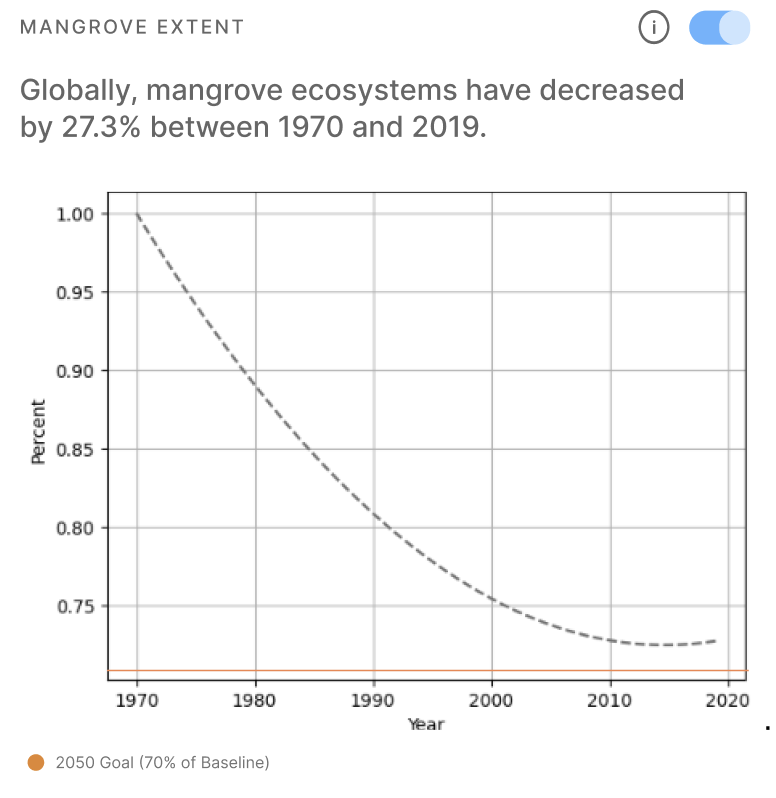

### Mangroves Extent Raster (3)
The mangrove extent raster was created from the Global Mangrove Watch Dataset from 2020. The vector dataset was rasterized using this code.

In [ ]:
# Using the vector_to_raster function defined in utils
vector_to_raster(
    vector_path='mangrove_extent.gpkg', #change paths accordingly
    out_raster_path='mangrove_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

 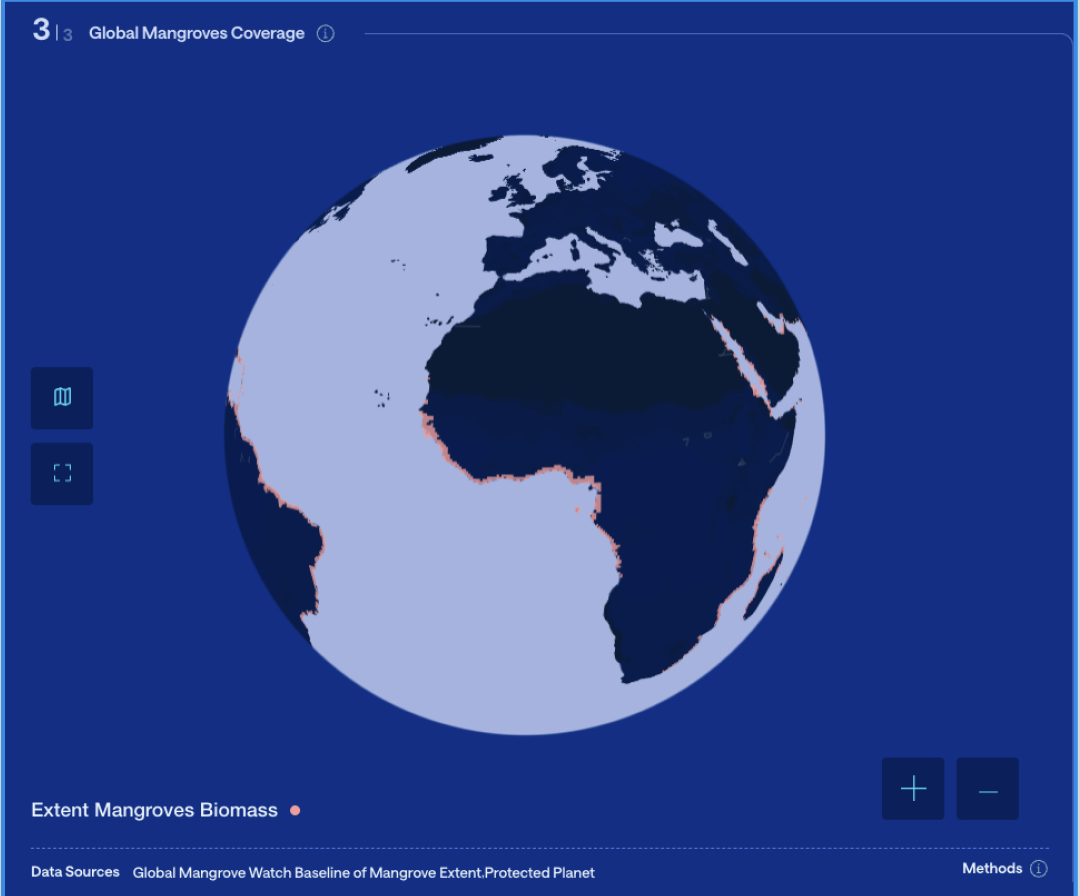

### Mangroves Extent in EEZ (4 and 11)
The EEZ and mangroves extent was done using QGIS vector intersections. The EEZ shapefile was merged with the ne_10m land vector. The EEZ + Land merged file covers the entire mangrove extent so the coverage is 100%. The extent figure is the same as the mangrove extent raster due to 100% coverage.

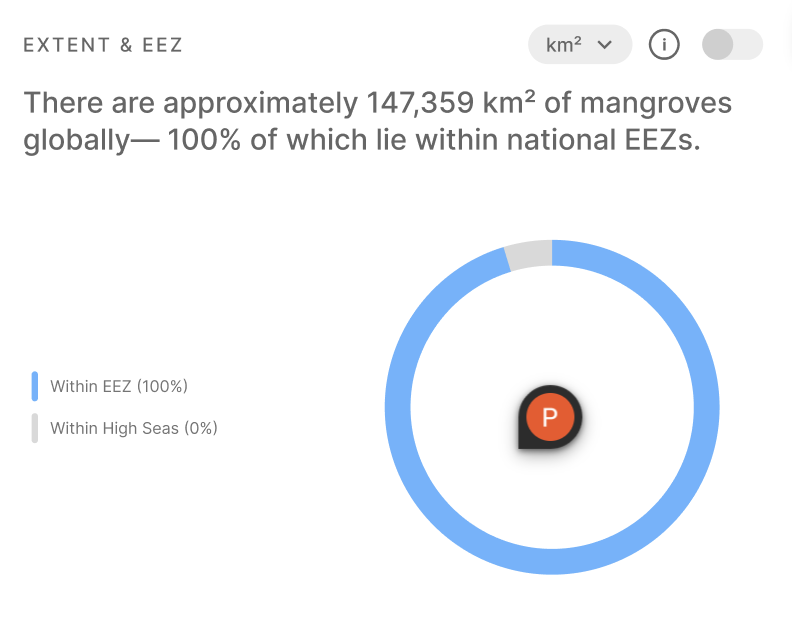

### Mangroves (5)

This dataset was sourced directly from Global Mangrove Watch and the Global Mangrove Extent Change 1996–2020: GMW Version 3.0 product. All gain, loss, and net-change values reflect the official estimates provided in that global dataset and the [GMW v3 study by Bunting et al., 2022](https://www.mdpi.com/2072-4292/14/15/3657) 

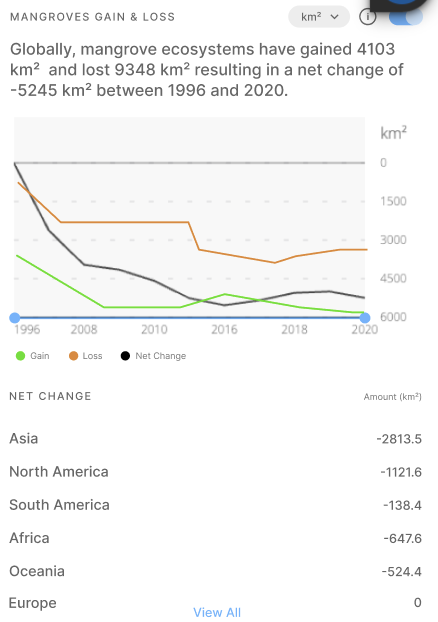

### Mangroves (6 and 12)
The drivers of change % was directly obtained from Global Mangrove Watch - https://www.globalmangrovewatch.org/

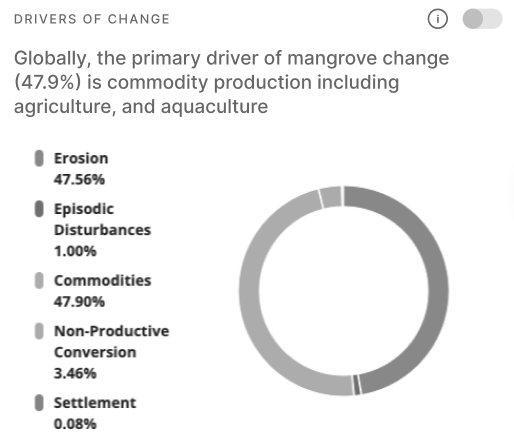

### Mangroves (7)

In [ ]:
# Source data for mangrove species is from IUCN here in a shapefile format with extent - https://www.iucnredlist.org/resources/spatial-data-download
# The mangroves shapefile was converted to a csv

import geopandas as gpd
import os

# ---- CONFIGURE FILES ----
shapefile_path = "data/mangroves_iucn.shp"  # Change these paths as needed
output_csv_path = "data/mangroves_iucn_species.csv"     
# --------------------------

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Drop the geometry column
df = gdf.drop(columns="geometry")

# Save to CSV
df.to_csv(output_csv_path, index=False)

# Create the species pie chart
# Count occurrences of each status for the pie chart
counts = df["Status"].value_counts().to_dict()

# Output JSON file
output_path = "mangrove_species_status_counts.json"

with open(output_path, "w") as f:
    json.dump(counts, f, indent=4)

print("Saved:", output_path)

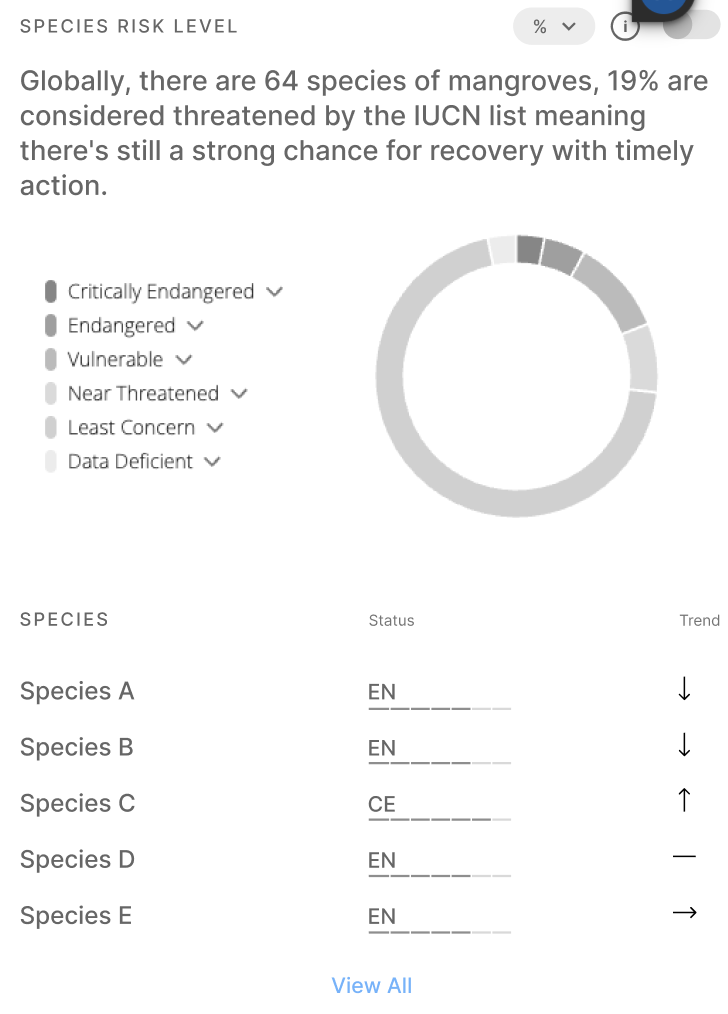

### Mangroves (13)

In [ ]:
# Pie charts per IUCN species habitat for marine regions
# Marine regions was downloaded from Marine Regions - https://www.marineregions.org/downloads.php - the IHO Sea Areas dataset is used

def attach_iucn_to_marine(marine_fp, iucn_fp, out_fp=None):
    """
    Spatially join marine polygons with all intersecting IUCN ecosystem attributes.
    
    Parameters
    ----------
    marine_fp : str
        Path to marine areas shapefile (must contain NAME, ID, etc.)
    iucn_fp : str
        Path to IUCN ecosystem shapefile (all attributes preserved)
    out_fp : str, optional
        Output path to save the joined layer. If None, no file is written.
    
    Returns
    -------
    GeoDataFrame
        A GeoDataFrame where each marine polygon appears once for each
        intersecting IUCN ecosystem feature, with ALL attributes preserved.
    """
    
    # --- 1. Read data ---
    marine = gpd.read_file(marine_fp)
    iucn = gpd.read_file(iucn_fp)

    # --- 2. Ensure CRS matches ---
    if marine.crs != iucn.crs:
        iucn = iucn.to_crs(marine.crs)

    # --- 3. Spatial join ---
    joined = gpd.sjoin(
        marine,
        iucn,
        how="left",              # keep all marine polygons
        predicate="intersects",
        lsuffix="_marine",
        rsuffix="_iucn"
    )

    # --- 4. Save output if requested ---
    if out_fp:
        joined.to_file(out_fp)
    
    return joined

result = attach_iucn_to_marine(
    marine_fp="World_Seas_IHO_v3/World_Seas_IHO_v3.shp",
    iucn_fp="IUCN_Mangroves_Habitat.gpkg",
    out_fp="IUCN_PIE_CHART/marine_areas_with_iucn_mangroves.shp"
)


### Mangroves (8 and 14)

The geopackage for mangrove alerts was downloaded from Global Mangrove Watch - https://storage.googleapis.com/mangrove_atlas/deforestation-alerts/Downloads/gmw_alerts_latest.gpkg

In [ ]:
# Mangrove alerts were obtained from Global Mangrove Watch

import json
from collections import Counter
from datetime import datetime
import geopandas as gpd  # <-- added

# --- Convert GPKG to GeoJSON first ---
gpkg_path = "gmw_alerts.gpkg"                  # input GPKG
geojson_path = "mangroves_alerts.geojson"      # intermediate GeoJSON

gdf = gpd.read_file(gpkg_path)
gdf.to_file(geojson_path, driver="GeoJSON")

# Path to your GeoJSON file
geojson_path = "mangroves_alerts.geojson"  

# Output JSON file
output_path = "Fig_8_mangrove_monthly_alerts.json"

# --- Read features from GeoJSON file ---
with open(geojson_path, "r") as f:
    data = json.load(f)

# Handle both FeatureCollection and raw feature list
if isinstance(data, dict) and data.get("type") == "FeatureCollection":
    features = data.get("features", [])
elif isinstance(data, list):
    features = data
else:
    raise ValueError("Unsupported GeoJSON structure: expected FeatureCollection or list of Features")

# --- Aggregate by month from first_obs_date ---
months = []
for feat in features:
    props = feat.get("properties", {})
    date_str = props.get("first_obs_date")
    if not date_str:
        continue

    dt = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
    month_key = dt.strftime("%Y-%m")
    months.append(month_key)

counts = Counter(months)

output = {
    "alerts_per_month": [
        {"month": month, "count": count}
        for month, count in sorted(counts.items())
    ]
}

# --- Save to JSON file ---
with open(output_path, "w") as f:
    json.dump(output, f, indent=2)

print(f"Saved monthly alert summary to: {output_path}")

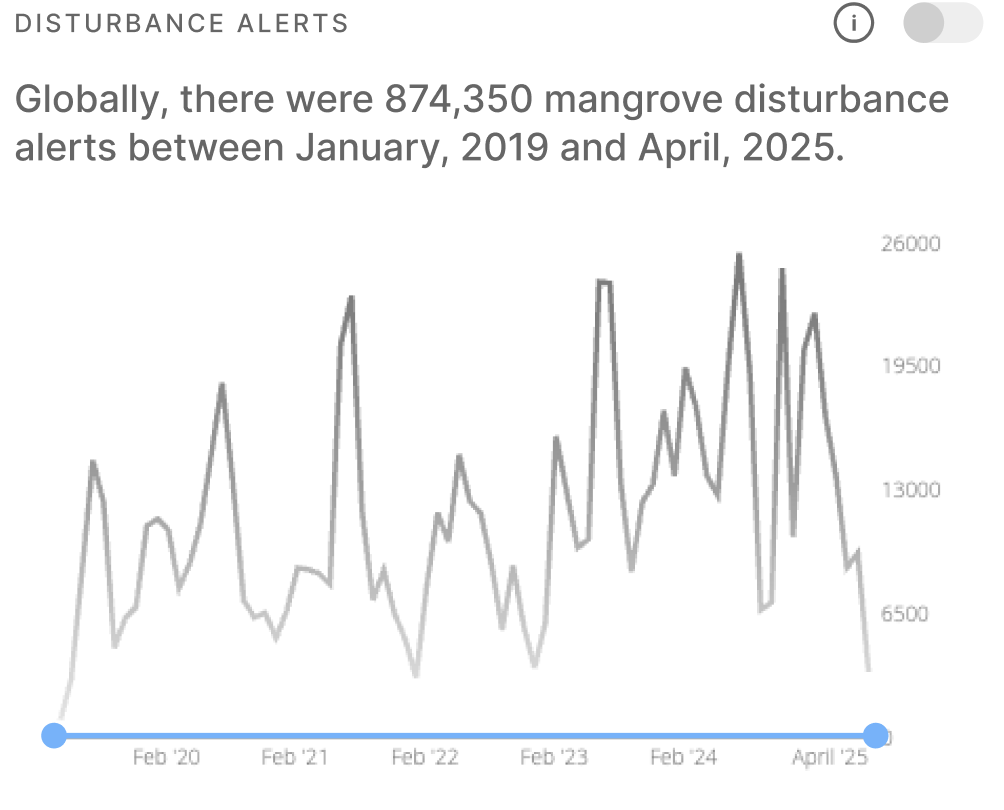

# Salt Marshes

### Salt Marshes (1)

In [ ]:
# Path to file
csv_file = "salt_marsh_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("⚠️ Warning: 'Rescaled' column not found in csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "salt_marsh_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

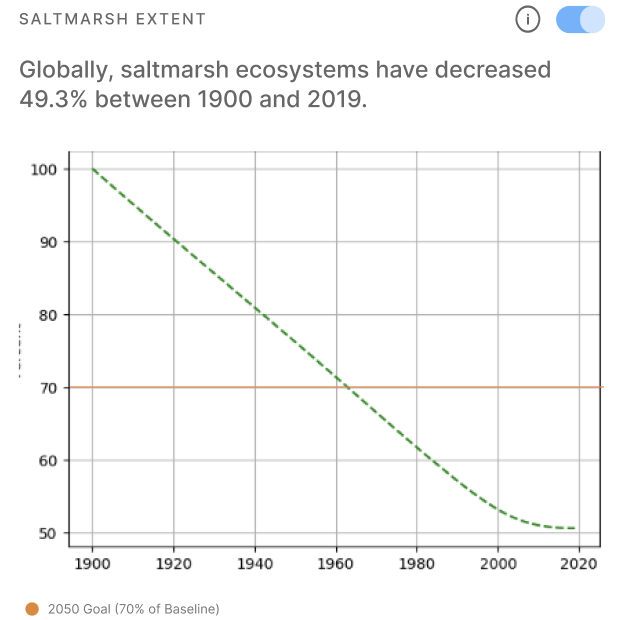

### Salt Marshes (2)

In [ ]:
# Vector to raster conversion using the previously defined vector_to_raster function - see utils
vector_to_raster(
    vector_path='salt_marsh_vector.shp', #change paths accordingly
    out_raster_path='Fig_2_salt_marsh_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

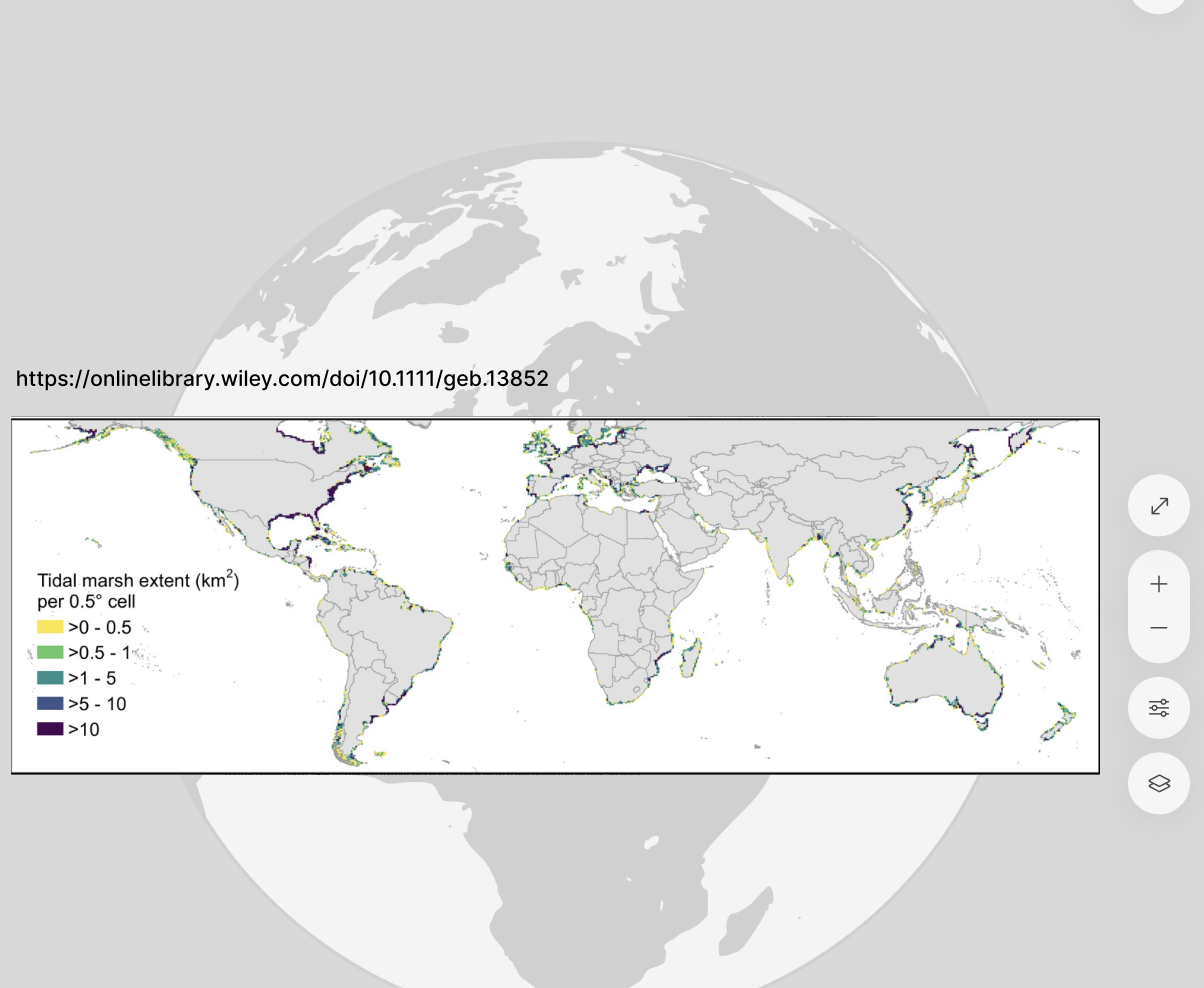

### Salt Marshes (3 and 8)

The EEZ and salt marsh extent was done using QGIS vector intersections. The EEZ shapefile was merged with the ne_10m land vector. The EEZ + Land merged file covers the entire mangrove extent so the coverage is 100%. The extent figure is the same as the salt marsh extent raster in Fig 2 due to 100% coverage.

In [ ]:
# Using the area statistics by continent function defined in utils

# Note that the salt marsh vector file was first DISSOLVED using QGIS before the area statistics extraction
inter, summary = area_by_continent(
    continents_fp="continents_200nm_buffer.gpkg",
    feature_fp="data/dissolved_salt_marsh.shp",
    continent_col="CONTINENT",
    output_csv="salt_marsh_area_by_continent.csv",
)

print(summary)

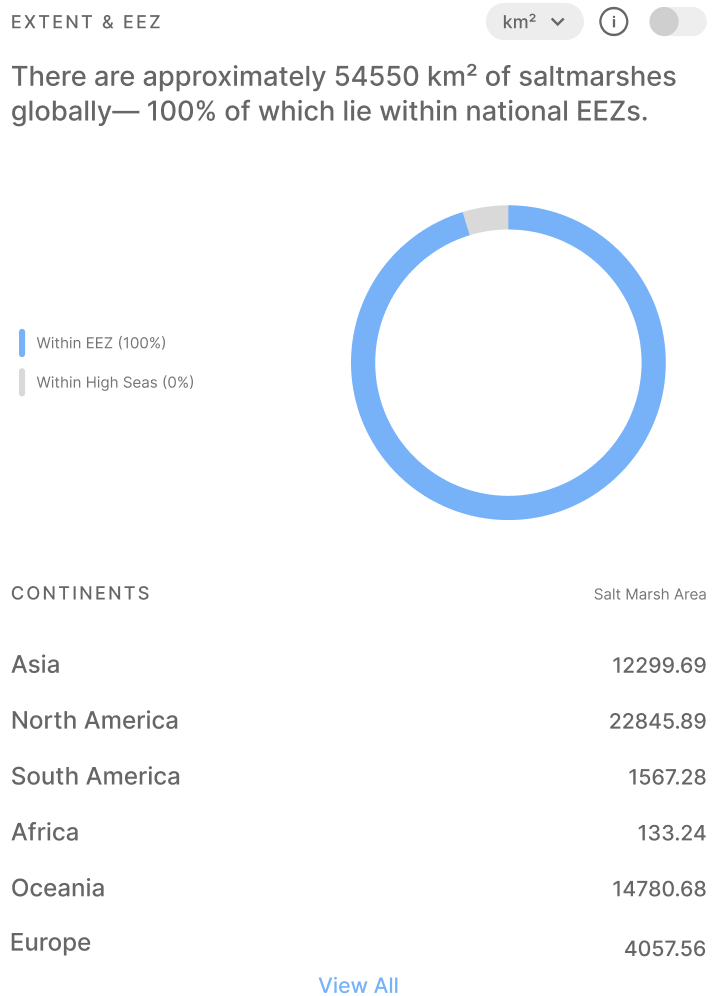

### Salt Marshes (5 and 10)

In [ ]:
## Sea Level Rise Data Processing
# Data was obtained from 
import xarray as xr
import rioxarray
import numpy as np

# --- Load NetCDF ---
ds = xr.open_dataset("cu_sea_level_trends_2025_rel1.nc")

# Extract trend layer
trend = ds["trends"]

print(trend)

# 1) Convert longitudes from 0–360 to -180–180 and then shift by half a cell
#    Grid step is 0.5°, so we shift by 0.25°.
res = float(trend.lon[1] - trend.lon[0])          # should be 0.5
trend = trend.assign_coords(
    lon=((trend.lon + 180) % 360) - 180 + res/2.0
)

# 2) Sort longitudes so they go from -180 → 180
trend = trend.sortby("lon")

# 2a) ***Fill the gap around 0°: add a longitude at 0 and interpolate***
lon_vals = trend.lon.values
# Only add if not already present (avoid duplicates on reruns)
if not np.any(np.isclose(lon_vals, 0.0)):
    lon_new = np.sort(np.append(lon_vals, 0.0))
    trend = trend.interp(lon=lon_new)

# 3) Rename dims to x/y for rioxarray
trend = trend.rename({"lat": "y", "lon": "x"})

# 4) Set spatial dims + CRS
trend = trend.rio.set_spatial_dims(x_dim="x", y_dim="y")
trend = trend.rio.write_crs("EPSG:4326")

# 5) Threshold: >= 4 mm/yr
threshold_mask = (trend >= 4).astype("uint8")

# 6) Ensure spatial metadata on the mask
threshold_mask = threshold_mask.rio.set_spatial_dims(x_dim="x", y_dim="y")
threshold_mask = threshold_mask.rio.write_crs("EPSG:4326")

# 7) Save as GeoTIFF
threshold_mask.rio.to_raster("sea_level_trend_ge_4mm_year_180.tif")

print("Saved: sea_level_trend_ge_4mm_year_180.tif")


In [ ]:
# Calculating the percentage of salt marshes overlap within areas of sea level rise > 4mm/yr
# Create the salt marsh extent file within the sea level rise > 4 mm/yr raster

salt_marsh_extent, salt_marsh_stats = raster_vector_intersection_stats(
    raster_path="sea_level_trend_ge_4mm_year_180.tif",
    vector_path="salt_marsh_vector.shp",
    out_intersection="salt_marsh_intersection.gpkg"
)

print("Salt Marsh Stats:", salt_marsh_stats)

# For the actual areas, we can also open the salt marsh vector intersection in QGIS and find the dissolved area of the intersection and divide by the total dissolved area of the salt marsh extent

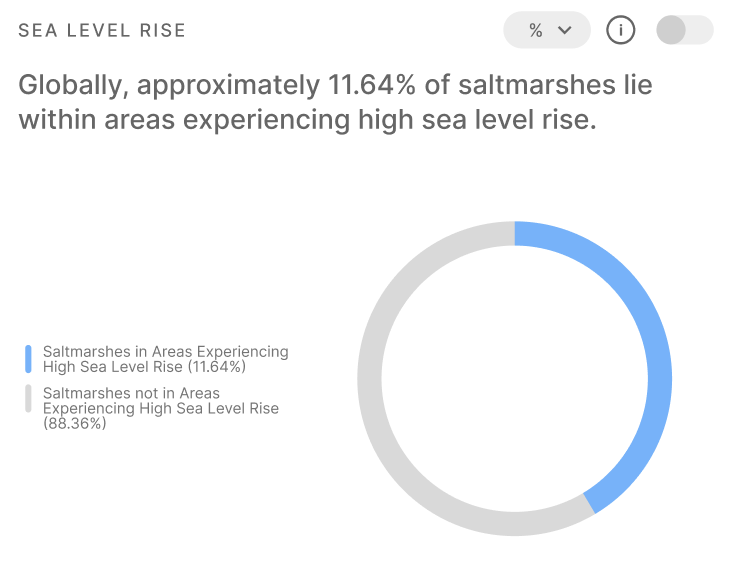

### Salt Marsh (6 and 11)

The Protected Areas and salt marsh extent was done using QGIS vector intersections due to large file sizes. Here are the steps:
1. Merge WDPA MPA and OECM layers into a single protected areas shapefile in QGIS.
3. Use Vector → Geoprocessing → Intersection to intersect the merged protected areas layer with the salt marsh vector layer.
4. Dissolve the intersection extent layer so it forms one unified polygon representing total habitat extent within protected areas.
5. Open the attribute table of the intersection output and create a new area field using the Field Calculator with the expression $area.
7. The resulting area values represent the protected salt marsh area, which can then be summed or analyzed as needed.

The intersection area is then divided by the total salt marsh vector area and the percentage is obtained and the intersection layer is exported as a geojson and geotiff for Fig 11.

### Salt Marsh (7 and 12)

# Seagrass

### Seagrass Fig 1

In [ ]:
# Path to file
csv_file = "seagrass_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("Warning: 'Rescaled' column not found in csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "seagrass_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

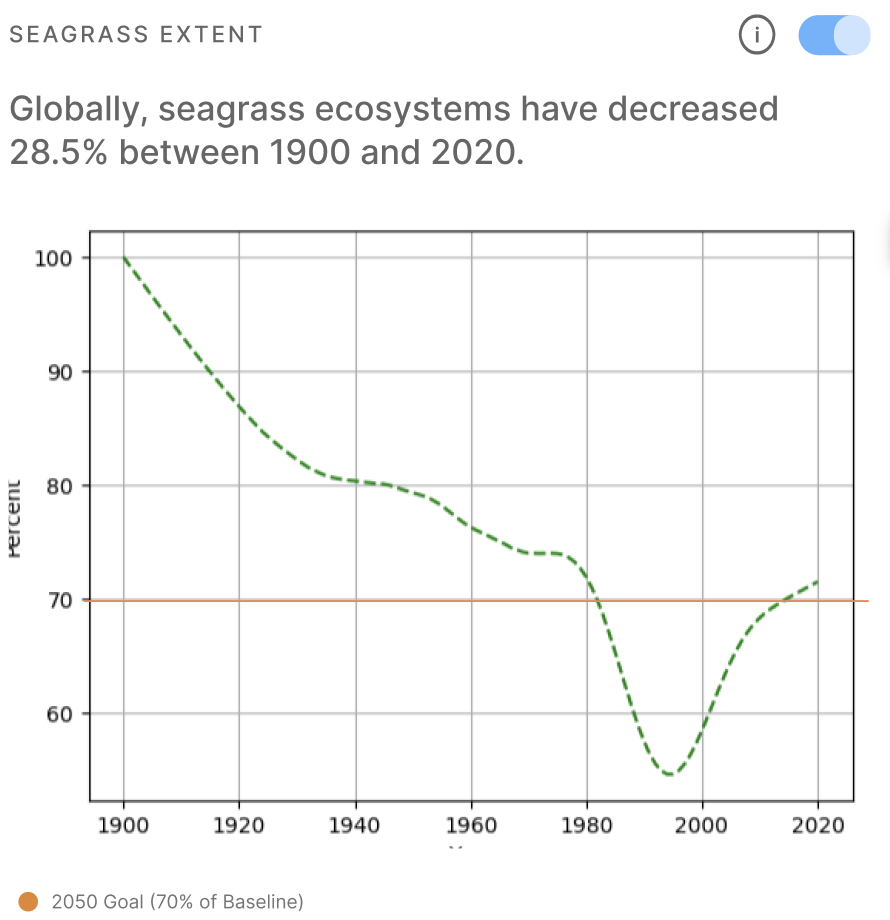


### Seagrass (2)

In [ ]:
# Use the vector_to_raster function predefined in utils above
vector_to_raster(
    vector_path='seagrass_extent.shp', #change paths accordingly
    out_raster_path='Fig_2_seagrass_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

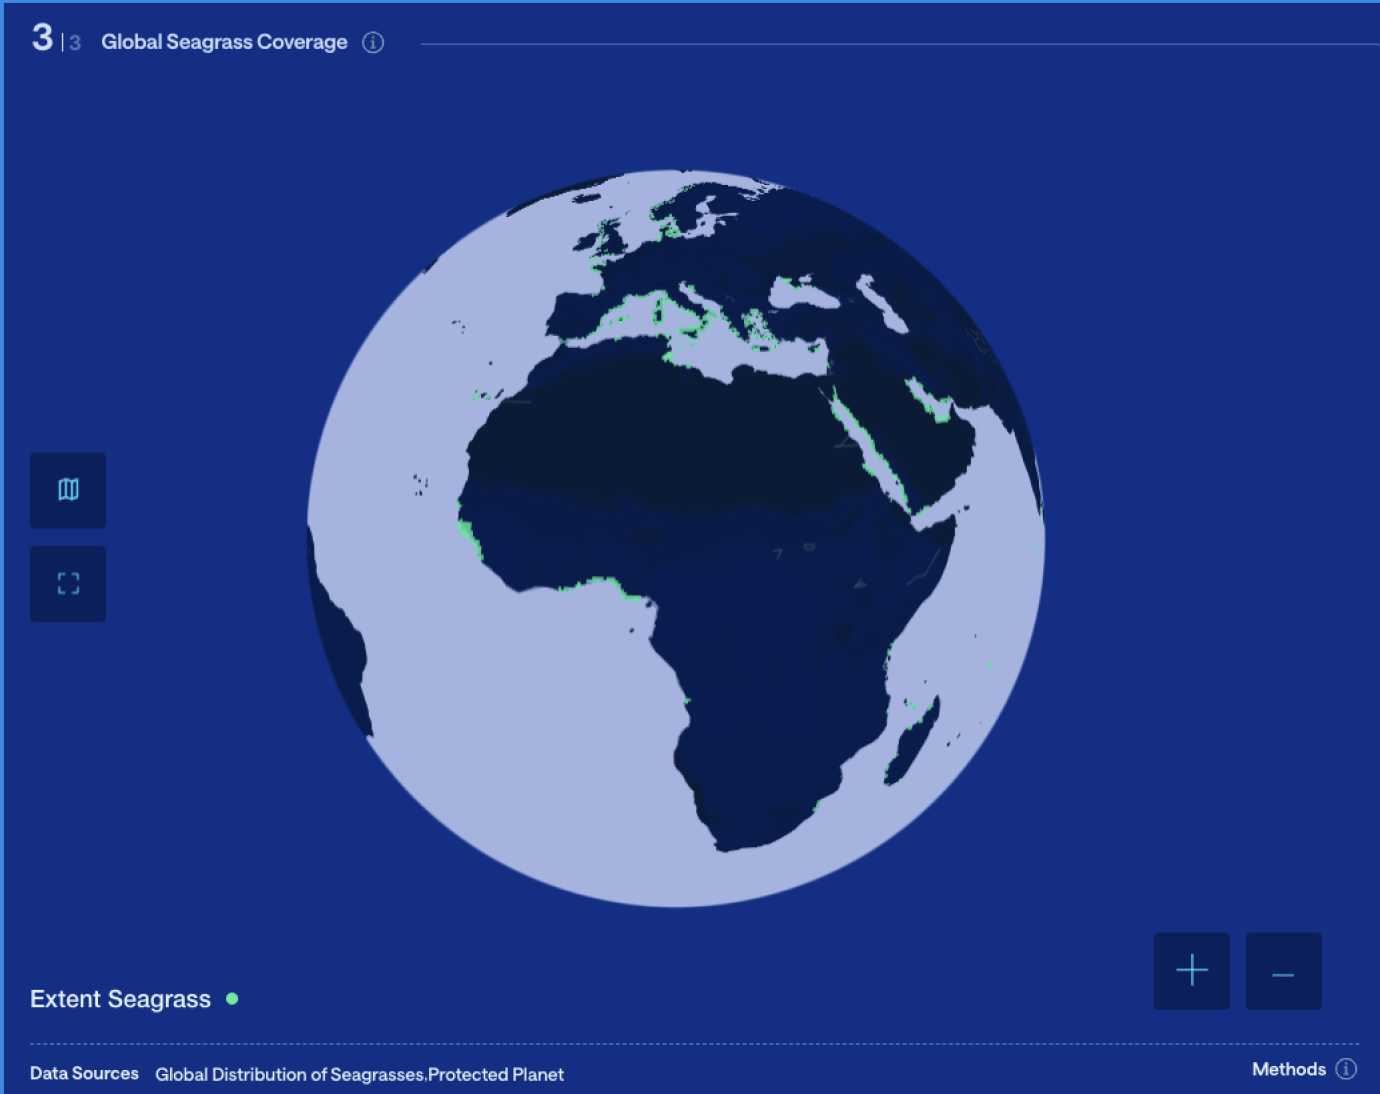


### Seagrass (3 and 12)

The EEZ dataset used was downloaded from Marine Regions - https://www.marineregions.org/downloads.php

The ne_10m land mask dataset was downloaded from here - https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-land/

The EEZ and seagrass extent analysis was performed using QGIS vector intersections. First, the EEZ shapefile was merged with the ne_10m_land vector layer to ensure complete coverage across all coastal and marine areas. This combined EEZ + Land layer fully encompasses ~97% seagrass extent. 

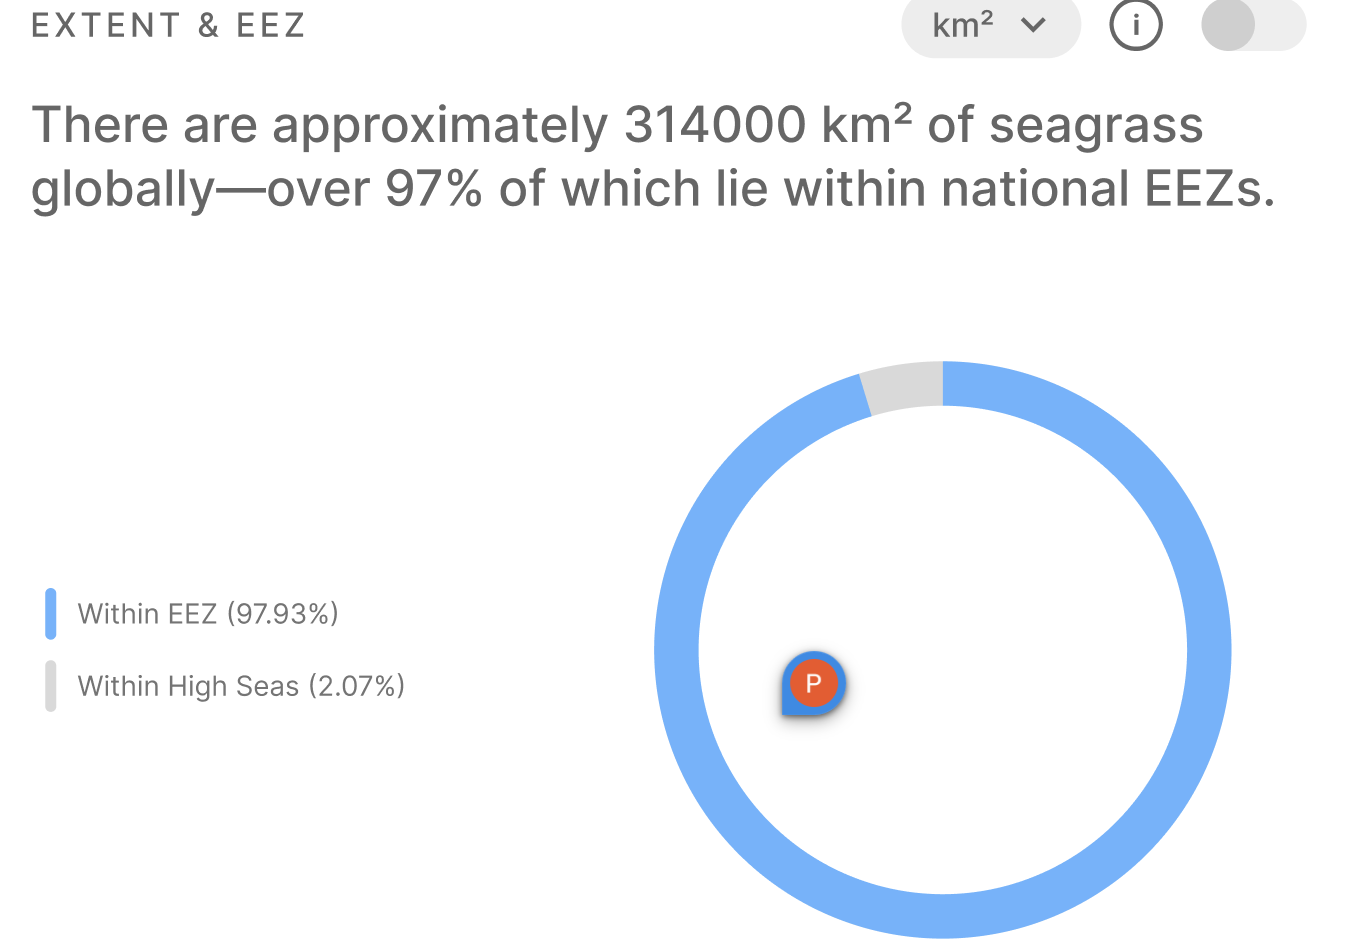

### Seagrass (7 and 15)

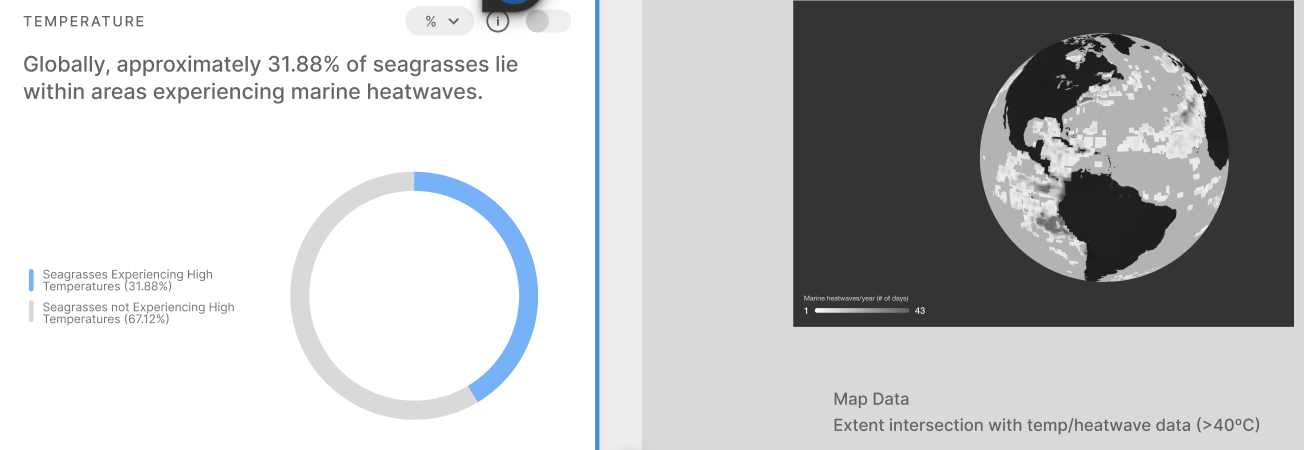

### Seagrass (8 and 16)

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from scipy import stats
import rioxarray

# Open dataset
ds = xr.open_dataset("OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc")
ph = ds['ph_total']  # dims: time, lat, lon

def calculate_trend_and_significance(x):
    if np.isnan(x).all():
        return np.nan, np.nan, np.nan
    else:
        slope, intercept, _, p_value, _ = stats.linregress(range(len(x)), x)
        return slope, intercept, p_value

# Apply across the time dimension at each grid cell
trend_slope, trend_intercept, trend_p = xr.apply_ufunc(
    calculate_trend_and_significance,
    ph,
    input_core_dims=[['time']],          # function takes a 1D time series
    output_core_dims=[[], [], []],       # scalar outputs per grid cell
    vectorize=True,                      # loop over lat/lon
    dask='parallelized',                 # works if data is dask-backed
    output_dtypes=[float, float, float]  # data types of outputs
)

# Name the outputs and attach coords
trend_slope = trend_slope.rename("ph_trend_slope")
trend_intercept = trend_intercept.rename("ph_trend_intercept")
trend_p = trend_p.rename("ph_trend_pvalue")

# Define "significant acidification":
#   - slope < 0 (pH decreasing => acidification)
#   - p-value < 0.05 (statistically significant)
sig_acid_trend = xr.where(
    (trend_slope < 0) & (trend_p < 0.05),
    trend_slope,                         # keep slope where significant acidification
    np.nan                               # NaN elsewhere
).rename("sig_acidification_trend")

print("sig_acid_trend created.")
print("sig_acid_trend dims:", sig_acid_trend.dims)

# --- Prepare for GeoTIFF with rioxarray ---
# Ensure lon/lat are recognized as spatial dims and assign CRS
sig_acid_trend = sig_acid_trend.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
sig_acid_trend = sig_acid_trend.rio.write_crs("EPSG:4326", inplace=False)

# --- Export as GeoTIFF ---
sig_acid_trend.rio.to_raster("significant_acidification_trend.tif")

# Next, the intersection of seagrass extent (vector) with this significant acidification tif file was obtained using the code below

# -------------------------------------------------------------------
# INPUTS – update these paths
# -------------------------------------------------------------------
raster_path = "significant_acidification_trend.tif"
vector_path = "seagrass_extent.shp"
vector_layer = None  # or layer name if needed

# -------------------------------------------------------------------
# 1. Read polygons
# -------------------------------------------------------------------
poly_gdf = gpd.read_file(vector_path, layer=vector_layer) if vector_layer else gpd.read_file(vector_path)

# -------------------------------------------------------------------
# 2. Build polygons from raster cells where raster > 0
# -------------------------------------------------------------------
with rasterio.open(raster_path) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata
    raster_crs = src.crs

    # mask = True where raster value > 0
    mask = data < 0
    if nodata is not None:
        mask &= (data != nodata)

    # Extract raster>0 regions as polygons
    raster_geoms = []
    for geom, val in shapes(data, mask=mask, transform=transform):
        raster_geoms.append(shape(geom))

# Merge all raster>0 polygons into one
raster_union = gpd.GeoSeries(raster_geoms, crs=raster_crs).unary_union
raster_union_gdf = gpd.GeoDataFrame(geometry=[raster_union], crs=raster_crs)
# -------------------------------------------------------------------
# 3. Reproject polygons if needed
# -------------------------------------------------------------------
if poly_gdf.crs != raster_union_gdf.crs:
    poly_gdf = poly_gdf.to_crs(raster_union_gdf.crs)

# -------------------------------------------------------------------
# 4. Intersect polygons with raster>0 area
# -------------------------------------------------------------------
result = gpd.overlay(poly_gdf, raster_union_gdf, how="intersection")

print(result.head())

# Save Intersection
result.to_file("seagrass_acidity.geojson", driver="geoJSON") # Fig 16

# Use a Proj4 string for Mollweide (equal-area) to avoid EPSG db issues
moll_crs = "ESRI:54009"

# Reproject raster mask and vectors to Mollweide for area computation
raster_union_moll = raster_union_gdf.to_crs(moll_crs)
poly_moll = poly_gdf.to_crs(moll_crs)
result_reproj = result.to_crs(moll_crs)

# Compute total intersection area in Mollweide (m²)
if result_reproj.empty:
    result_area = 0.0
else:
    result_diss_moll = result_reproj.dissolve()
    result_area = result_diss_moll.geometry.area.iloc[0]

# Dissolve vectors into one polygon and compute area in Mollweide (m²)
vector_diss_moll = poly_moll.dissolve()
vector_area = vector_diss_moll.geometry.area.iloc[0]

percentage = (result_area / vector_area) * 100
print(f"Percentage of vector area over parent area: {percentage:.2f}%")

print(f"Result  area (>0) [Mollweide]: {result_area:,.2f} m²")
print(f"Total dissolved vector area [Mollweide]: {vector_area:,.2f} m²")

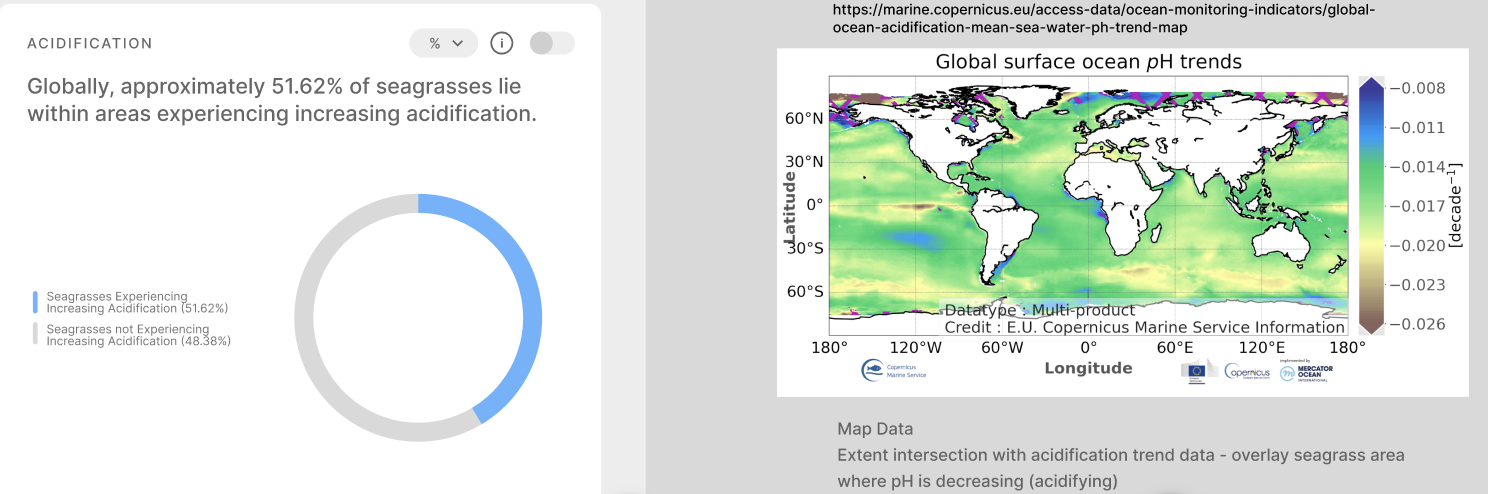

### Seagrass (9 and 17)

In [ ]:
# IUCN Species data downloaded from the IUCN Red List site


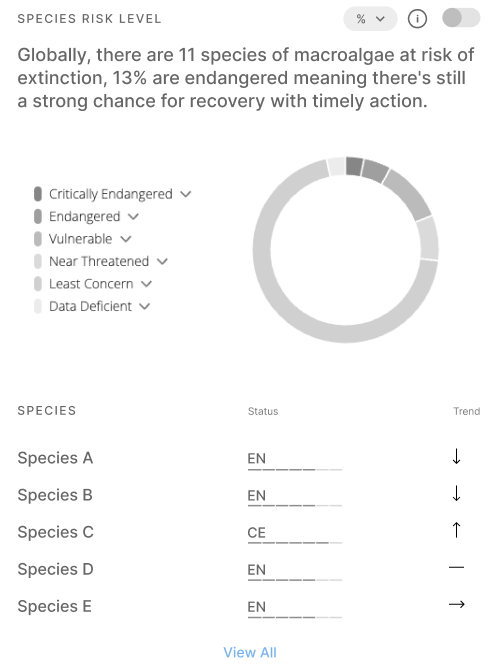

### Seagrass (10 and 18)

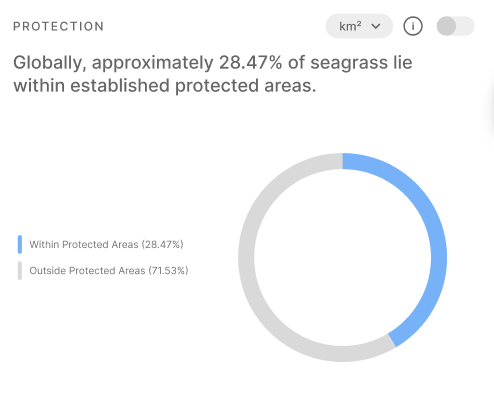

# Tropical Warm Water Corals

### Corals (1)

In [ ]:
# Path to file
csv_file = "coral_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("⚠️ Warning: 'Rescaled' column not found in mangroves_timeseries.csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "corals_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

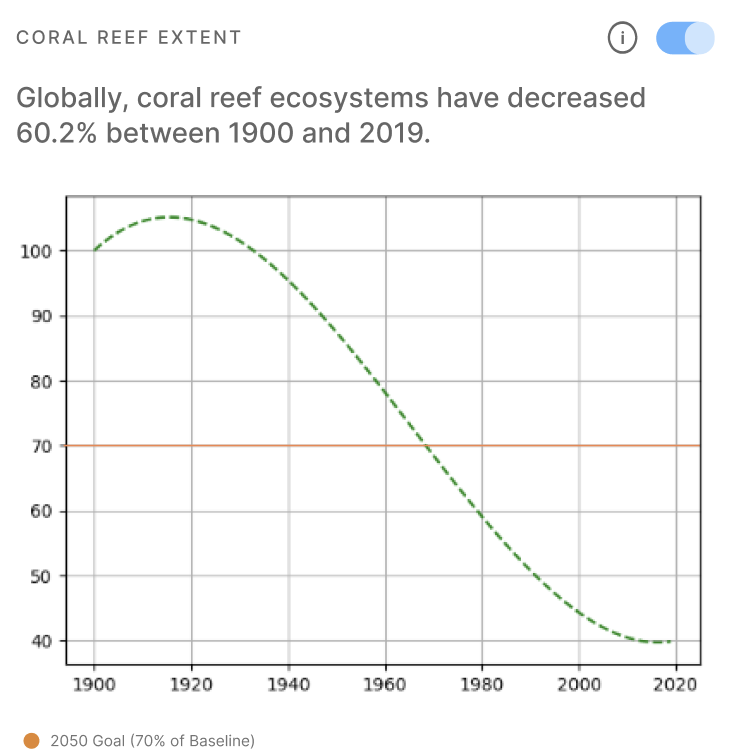

### Corals (2)

In [ ]:
# Use the vector_to_raster function predefined in utils above
vector_to_raster(
    vector_path='14_001_WCMC008_CoralReefs2018_v4_1/01_Data/WCMC008_CoralReef2018_Py_v4_1.shp', #change paths accordingly
    out_raster_path='corals_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

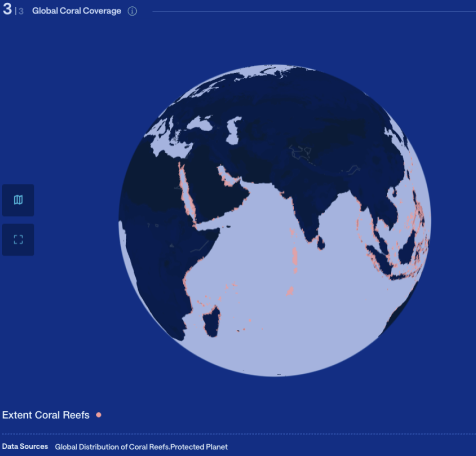

### Corals (3 and 11)

The EEZ dataset used was downloaded from Marine Regions - https://www.marineregions.org/downloads.php

The ne_10m land mask dataset was downloaded from here - https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-land/

The EEZ and tropical coral extent was done using QGIS vector intersections. The EEZ shapefile was merged with the ne_10m land vector. The EEZ + Land merged file covers the entire coral extent so the coverage is 100%. The extent figure is the same as the coral extent raster due to 100% coverage.

In [ ]:
# Continental Stats using the same area_by_continent function defined above 
# Australia + Oceania are combined into Oceania
inter, summary = area_by_continent(
    continents_fp="continents_200nm_buffer.gpkg",
    feature_fp="merged_dissolved_warm_corals.gpkg",
    continent_col="CONTINENT",
    output_csv="coral_area_by_continent.csv",
)

print(summary)

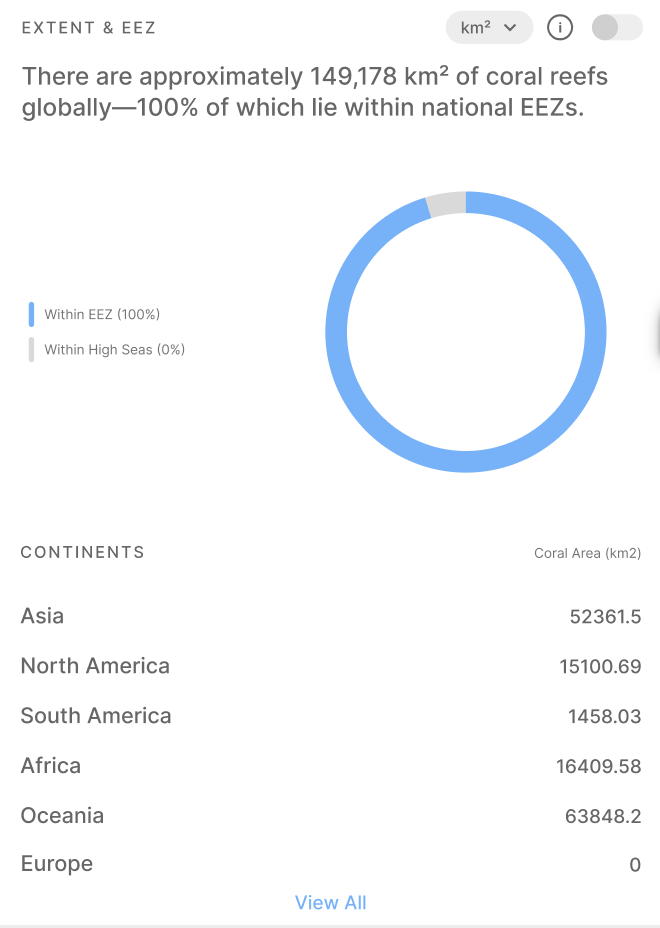

### Corals (4)

This plot and the numbers were recreated from the [Status of Coral Reefs of the World: 2020 Report](https://gcrmn.net/2020-report-v1-2023/)

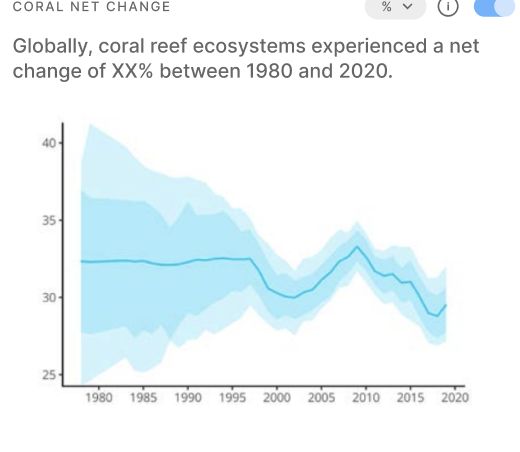

### Corals (6 and 12)

In [ ]:
# First, all of the files of coral heat stress for 2024 were downloaded using the script below
# The source link for all files are from NOAA's HTTP server here - https://www.ncei.noaa.gov/data/oceans/crw/5km/v3.1/nc/v1.0/daily/hs/2024/

import os
import requests
from bs4 import BeautifulSoup

BASE_URL = "https://www.ncei.noaa.gov/data/oceans/crw/5km/v3.1/nc/v1.0/daily/hs/2024/"
OUTPUT_DIR = "crw_hs_2024_nc"   # folder where files will be saved -change as needed

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Fetching index page...")
resp = requests.get(BASE_URL)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, "html.parser")

# Find all links that end with .nc
file_names = [
    a["href"]
    for a in soup.find_all("a")
    if a.get("href", "").endswith(".nc")
]

print(f"Found {len(file_names)} NetCDF files.")

for name in file_names:
    url = BASE_URL + name
    out_path = os.path.join(OUTPUT_DIR, name)

    # Skip if already downloaded
    if os.path.exists(out_path):
        print(f"Already exists, skipping: {name}")
        continue

    print(f"Downloading {name} ...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

print("Done.")

# Now you should have all nc files for 2024 downloaded to a local folder path

In [ ]:
import xarray as xr
import os
import numpy as np
import rioxarray  # pip install rioxarray rasterio

DATA_DIR      = "Coral_Heat_Stress_2024_nc"   # <--- folder where the above downloaded nc files are stored
OUT_MEAN_TIF  = "heat_stress_area_alert_ge1_mean_2024.tif"
OUT_BIN_TIF   = "heat_stress_ge1_anyday_2024.tif"

# ------------------------------------------------------------
# 1. Open all daily NetCDFs as one dataset
# ------------------------------------------------------------
files = sorted([
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR)
    if f.endswith(".nc")
])

print(f"Found {len(files)} NetCDF files")

# Use chunks so dask handles the big array lazily
ds = xr.open_mfdataset(files, combine="by_coords", chunks={"time": 1})

# The alert variable
alert = ds["hotspot"]  # shape: (time, lat, lon)

# ------------------------------------------------------------
# 2. Threshold each day (alert >= 1 degree celsius anomaly)  -> daily binary 0/1
# ------------------------------------------------------------
binary_daily = (alert >= 1).astype("int8")

# ------------------------------------------------------------
# 3. Mean across time (fraction of days with alert >= 1 degrees celsius anomaly)
# ------------------------------------------------------------
mean_over_time = binary_daily.mean(dim="time")  # float in [0, 1]
mean_over_time.name = "hotspot_area_alert_ge1_mean"

# ------------------------------------------------------------
# 4. Binary 0/1 raster from the mean
#    1 = at least one alert day in 2024, 0 = none
# ------------------------------------------------------------
binary_mean = (mean_over_time > 0).astype("int8")
binary_mean.name = "hotspot_area_alert_ge1_anyday"

# ------------------------------------------------------------
# 5. Write both outputs as GeoTIFFs using rioxarray
# ------------------------------------------------------------
# Set spatial dims and CRS so GeoTIFF is georeferenced
for da, out_tif in [(mean_over_time, OUT_MEAN_TIF),
                    (binary_mean, OUT_BIN_TIF)]:

    # IMPORTANT: use positional args, not x="lon", y="lat"
    da = da.rio.set_spatial_dims("lon", "lat", inplace=False)
    da = da.rio.write_crs("EPSG:4326", inplace=False)

    da.rio.to_raster(out_tif)
    print(f"Saved GeoTIFF: {out_tif}")

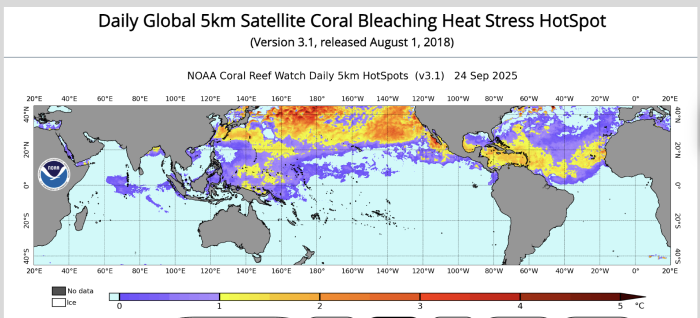

### Corals (7 and 13)

In [ ]:
# Coral species IUCN data downloaded from IUCN Red List 
# Fig 7 species list and pie chart
# ---- CONFIGURE FILES ----
shapefile_path = "data/corals_iucn.shp"  # Change these paths as needed
output_csv_path = "data/Fig_7_corals_iucn_species.csv"     
# --------------------------

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Drop the geometry column
df = gdf.drop(columns="geometry")

# Save to CSV
df.to_csv(output_csv_path, index=False)

# Create the species pie chart
# Count occurrences of each status for the pie chart
counts = df["Status"].value_counts().to_dict()

# Output JSON file
output_path = "coral_species_status_counts.json"

with open(output_path, "w") as f:
    json.dump(counts, f, indent=4)

print("Saved:", output_path)

# ---- CONFIGURE FILES ----
shapefile_path = "data/corals_iucn.shp"  # Change these paths as needed
output_csv_path = "data/corals_iucn_species.csv"     
# --------------------------

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Drop the geometry column
df = gdf.drop(columns="geometry")

# Save to CSV
df.to_csv(output_csv_path, index=False)

# Create the species pie chart
# Count occurrences of each status for the pie chart
counts = df["Status"].value_counts().to_dict()

# Output JSON file
output_path = "coral_species_status_counts.json"

with open(output_path, "w") as f:
    json.dump(counts, f, indent=4)

print("Saved:", output_path)

# For figure 13 pie charts by marine regions
# Using the above defined attach_iucn_to_marine function to get status of IUCN coral species by marine regions
result = attach_iucn_to_marine(
    marine_fp="World_Seas_IHO_v3/World_Seas_IHO_v3.shp",
    iucn_fp="IUCN_Warm_Corals_Habitat.gpkg",
    out_fp="IUCN_PIE_CHART/marine_areas_with_iucn_CORALS.shp"
)

# Convert the shapefile into a json of species and a separate json by status count and marine regions coordinates


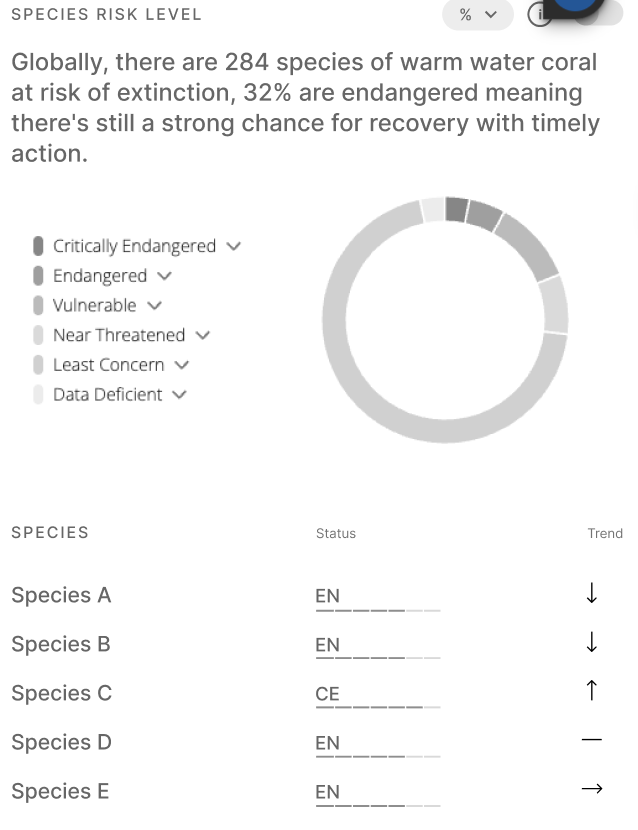

### Corals (8)

In [ ]:
import xarray as xr
import os
import numpy as np
import rioxarray  # pip install rioxarray rasterio

DATA_DIR      = "Bleaching"   # <--- change
OUT_MEAN_TIF  = "bleaching_alert_area_alert_ge1_mean_2024.tif"
OUT_BIN_TIF   = "bleaching_alert_area_alert_ge1_anyday_2024.tif"

# ------------------------------------------------------------
# 1. Open all daily NetCDFs as one dataset
# ------------------------------------------------------------
files = sorted([
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR)
    if f.endswith(".nc")
])

print(f"Found {len(files)} NetCDF files")

# Use chunks so dask handles the big array lazily
ds = xr.open_mfdataset(files, combine="by_coords", chunks={"time": 1})

# The alert variable
alert = ds["bleaching_alert_area"]  # shape: (time, lat, lon)

# ------------------------------------------------------------
# 2. Threshold each day (alert >= 1)  -> daily binary 0/1
# ------------------------------------------------------------
binary_daily = (alert >= 1).astype("int8")

# ------------------------------------------------------------
# 3. Mean across time (fraction of days with alert >= 1)
# ------------------------------------------------------------
mean_over_time = binary_daily.mean(dim="time")  # float in [0, 1]
mean_over_time.name = "bleaching_alert_area_alert_ge1_mean"

# ------------------------------------------------------------
# 4. Binary 0/1 raster from the mean
#    1 = at least one alert day in 2024, 0 = none
# ------------------------------------------------------------
binary_mean = (mean_over_time > 0).astype("int8")
binary_mean.name = "bleaching_alert_area_alert_ge1_anyday"

# ------------------------------------------------------------
# 5. Write both outputs as GeoTIFFs using rioxarray
# ------------------------------------------------------------
# Set spatial dims and CRS so GeoTIFF is georeferenced
for da, out_tif in [(mean_over_time, OUT_MEAN_TIF),
                    (binary_mean, OUT_BIN_TIF)]:

    # IMPORTANT: use positional args, not x="lon", y="lat"
    da = da.rio.set_spatial_dims("lon", "lat", inplace=False)
    da = da.rio.write_crs("EPSG:4326", inplace=False)

    da.rio.to_raster(out_tif)
    print(f"Saved GeoTIFF: {out_tif}")

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from scipy import stats
import rioxarray

# Open dataset
ds = xr.open_dataset("OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc")
ph = ds['ph_total']  # dims: time, lat, lon

# Your existing function
def calculate_trend_and_significance(x):
    if np.isnan(x).all():
        return np.nan, np.nan, np.nan
    else:
        slope, intercept, _, p_value, _ = stats.linregress(range(len(x)), x)
        return slope, intercept, p_value

# Apply across the time dimension at each grid cell
trend_slope, trend_intercept, trend_p = xr.apply_ufunc(
    calculate_trend_and_significance,
    ph,
    input_core_dims=[['time']],          # function takes a 1D time series
    output_core_dims=[[], [], []],       # scalar outputs per grid cell
    vectorize=True,                      # loop over lat/lon
    dask='parallelized',                 # works if data is dask-backed
    output_dtypes=[float, float, float]  # data types of outputs
)

# Name the outputs and attach coords
trend_slope = trend_slope.rename("ph_trend_slope")
trend_intercept = trend_intercept.rename("ph_trend_intercept")
trend_p = trend_p.rename("ph_trend_pvalue")

# Define "significant acidification":
#   - slope < 0 (pH decreasing => acidification)
#   - p-value < 0.05 (statistically significant)
sig_acid_trend = xr.where(
    (trend_slope < 0) & (trend_p < 0.05),
    trend_slope,                         # keep slope where significant acidification
    np.nan                               # NaN elsewhere
).rename("sig_acidification_trend")

print("sig_acid_trend created.")
print("sig_acid_trend dims:", sig_acid_trend.dims)

# --- Prepare for GeoTIFF with rioxarray ---
# Ensure lon/lat are recognized as spatial dims and assign CRS
sig_acid_trend = sig_acid_trend.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
sig_acid_trend = sig_acid_trend.rio.write_crs("EPSG:4326", inplace=False)

# --- Export as GeoTIFF ---
sig_acid_trend.rio.to_raster("significant_acidification_trend.tif")


### Corals (9 and 14)

The Protected Areas and warm corals extent was done using QGIS vector intersections due to large file sizes. Here are the steps:
1. Merge WDPA MPA and OECM layers into a single protected areas shapefile in QGIS.
3. Use Vector → Geoprocessing → Intersection to intersect the merged protected areas layer with the coral vector layer.
4. Dissolve the intersection extent layer so it forms one unified polygon representing total habitat extent within protected areas.
5. Open the attribute table of the intersection output and create a new area field using the Field Calculator with the expression $area.
7. The resulting area values represent the protected seamounts area, which can then be summed or analyzed as needed.

The intersection area is then divided by the total warm coral vector area and the percentage is obtained and the intersection layer is exported as a geojson and geotiff for Fig 11.

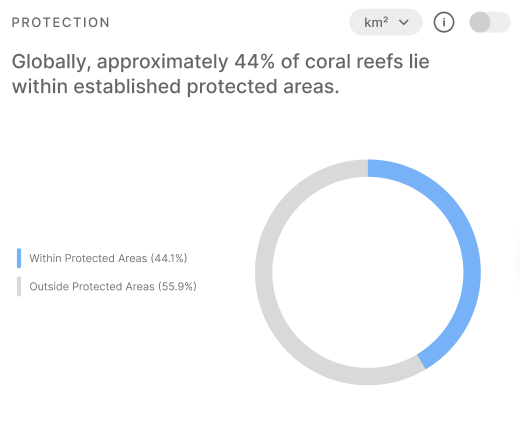

### Restoration Figures - Mangroves (10 and 16); Salt Marshes (7 and 12); Seagrass (11 and 19); Corals (10 and 15)

The following code collectively generates jsons and geojsons for restoration projects of mangroves, salt marshes, seagrass, and corals. The underlying data is from the [Rebuilding Marine Life paper by Duarte et al. 2020](https://www.nature.com/articles/s41586-020-2146-7)

In [ ]:
# This dataset is from 'Rebuilding Marine Life' - https://www.nature.com/articles/s41586-020-2146-7
# The code in this cell creates json files for the cumulative count of restoration projects
df = pd.read_csv("duarte_restoration.csv")

# ---- Compute cumulative projects by habitat and year ----
df_sorted = df.sort_values(by=["Habitat", "Year"])

cumulative = (
    df_sorted.groupby(["Habitat", "Year"])
    .size()
    .groupby(level=0)
    .cumsum()
    .reset_index(name="cumulative_projects")
)

# ---- Convert to JSON (ONLY cumulative counts) ----
cumulative_json = (
    cumulative.groupby("Habitat")
    .apply(lambda x: dict(zip(x["Year"], x["cumulative_projects"])))
    .to_dict()
)

# Print combined JSON (all habitats together)
print(json.dumps(cumulative_json, indent=4))

# ---- Helper to make safe filenames from habitat names ----
def habitat_to_json_filename(habitat):
    safe = re.sub(r'[^0-9a-zA-Z]+', '_', str(habitat).strip())
    return f"{safe.lower()}_cumulative_projects.json"

# ---- Save one JSON file per habitat ----
for habitat, series in cumulative_json.items():
    filename = habitat_to_json_filename(habitat)
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(series, f, ensure_ascii=False, indent=4)
    print(f"Saved cumulative time series for '{habitat}' to {filename}")

# ---- Compute and print totals ----
total_projects = df.groupby("Habitat").size()
print("\nTotal projects per habitat:")
print(total_projects)

# ---- Save totals as a CSV file ----
total_projects.to_csv("total_projects_by_habitat.csv", header=["total_projects"])

In [ ]:
#For creating geojsons of the restoration projects per habitat

# ---- FUNCTION: Convert ANY coordinate format to decimal degrees ----
def convert_coord(value):
    if pd.isna(value):
        return None
    
    s = str(value).upper().strip()
    
    # Normalize unicode quotation marks
    s = (
        s.replace("’", "'")
         .replace("‘", "'")
         .replace("''", '"')
         .replace("”", '"')
         .replace("“", '"')
    )

    # Remove degree symbol
    s = s.replace("°", "")

    # Extract direction (N/S/E/W)
    direction = None
    if s.endswith(("N", "S", "E", "W")):
        direction = s[-1]
        s = s[:-1].strip()

    # CASE 1: Simple decimal → return directly
    try:
        val = float(s)
        if direction == "S" or direction == "W":
            val = -val
        return val
    except:
        pass

    # CASE 2: DMS format: D° M' S"
    # Examples:
    # 37 15 54
    # 37° 15' 54"
    # 37 15’ 54’’
    dms = re.findall(r"(\d+(?:\.\d*)?)", s)
    if len(dms) >= 1:
        deg = float(dms[0])
        min_ = float(dms[1]) if len(dms) >= 2 else 0.0
        sec = float(dms[2]) if len(dms) >= 3 else 0.0

        decimal = deg + min_ / 60 + sec / 3600

        if direction in ["S", "W"]:
            decimal = -decimal
        
        return decimal

    return None


# ---- Read your file ----
df = pd.read_csv("duarte_restoration.csv")

df.columns = [c.strip() for c in df.columns]

# ---- Convert coordinates ----
df["Latitude"] = df["Latitude"].apply(convert_coord)
df["Longitude"] = df["Longitude"].apply(convert_coord)

# ---- Report rows that still couldn't be parsed ----
bad_rows = df[df["Latitude"].isna() | df["Longitude"].isna()]
if not bad_rows.empty:
    print("\n WARNING: Could not convert these rows:")
    print(bad_rows[["Habitat", "Location", "Latitude", "Longitude"]])

# Keep only valid numeric rows
df = df.dropna(subset=["Latitude", "Longitude"])

# ---- Helper for filenames ----
def habitat_to_filename(habitat):
    safe = re.sub(r'[^0-9a-zA-Z]+', '_', str(habitat).strip())
    return f"{safe.lower()}_points.geojson"

# ---- Write one GeoJSON per habitat ----
for habitat, g in df.groupby("Habitat"):
    features = []

    for _, row in g.iterrows():
        props = row.to_dict()
        props.pop("Latitude", None)
        props.pop("Longitude", None)

        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    float(row["Longitude"]),
                    float(row["Latitude"])
                ]
            },
            "properties": props
        }
        features.append(feature)

    geojson = {"type": "FeatureCollection", "features": features}

    filename = habitat_to_filename(habitat)
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(geojson, f, ensure_ascii=False, indent=4)

    print(f"✅ GeoJSON written for habitat '{habitat}' → {filename}")

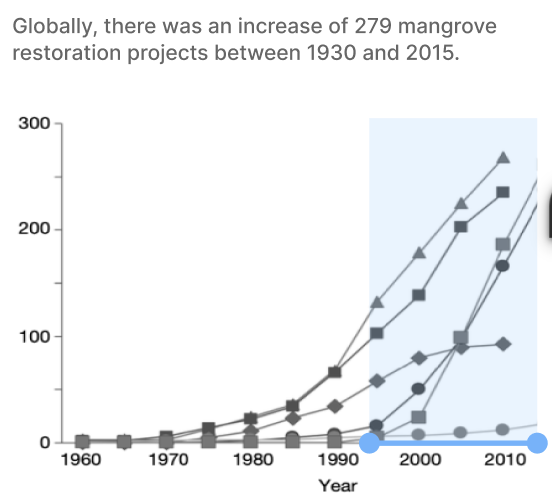

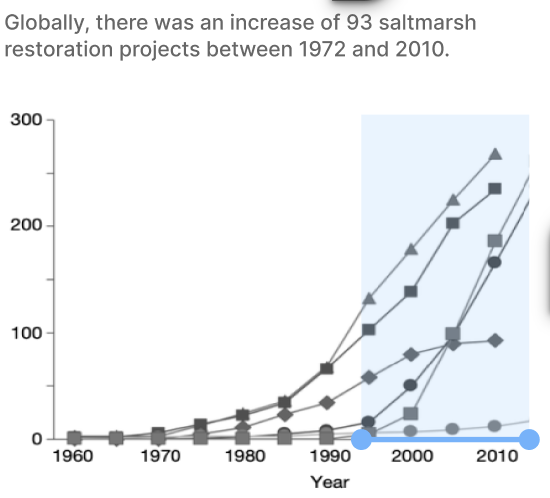

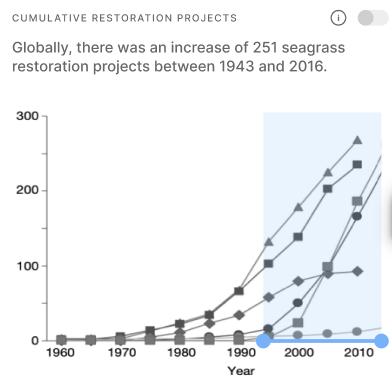

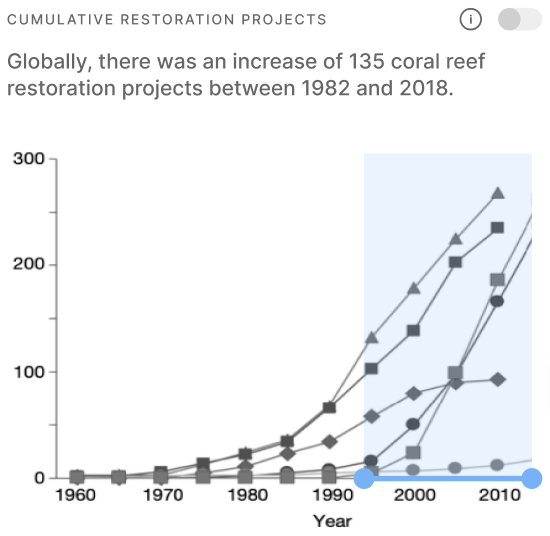

# Algal Forests

### Algal Forests (1)

In [ ]:
# Path to file
csv_file = "kelp_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("Warning: 'Rescaled' column not found in kelp_timeseries.csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "kelp_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

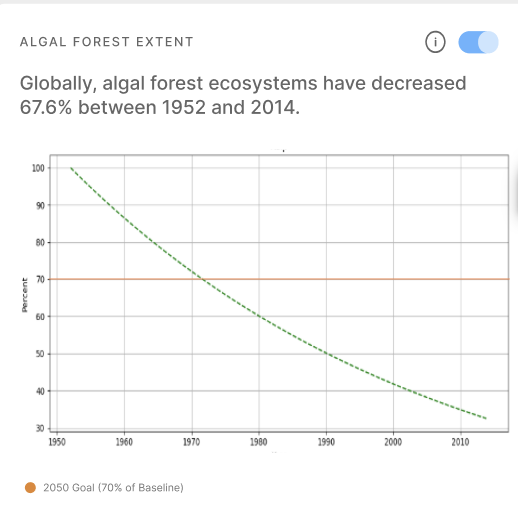

### Algal Forests (2)

In [ ]:
# Kelp data downloaded from here - https://data-gis.unep-wcmc.org/portal/home/item.html?id=feb74bba5aab4a7184b42c9de0f87a14
# Use the vector_to_raster function predefined in utils above
vector_to_raster(
    vector_path='Kelp UNEP.shp', #change paths accordingly
    out_raster_path='kelp_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

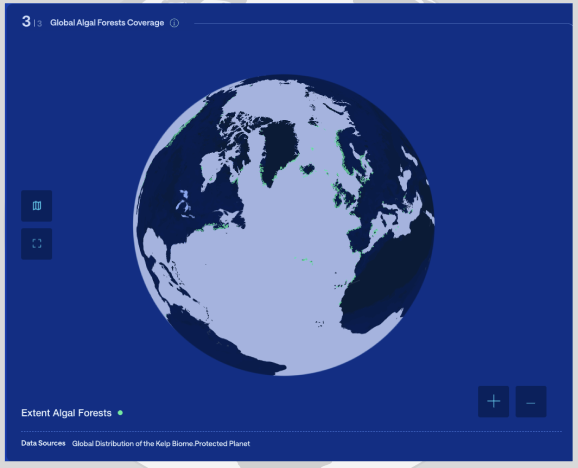

### Algal Forests (3 and 13)

All algal forests lie within the merged land and EEZ vector.
The EEZ dataset used was downloaded from Marine Regions - https://www.marineregions.org/downloads.php

The ne_10m land mask dataset was downloaded from here - https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-land/

The EEZ and algal forest extent was done using QGIS vector intersections. The EEZ shapefile was merged with the ne_10m land vector. The EEZ + Land merged file covers the entire kelp extent so the coverage is 100%. The EEZ raster for Fig 13 is the same as Fig 2)

In [ ]:
# Continental area statistics were calculated using the same function as above

# Australia + Oceania are combined into Oceania
inter, summary = area_by_continent(
    continents_fp="continents_200nm_buffer.gpkg",
    feature_fp="merged_dissolved_algal_forests.gpkg",
    continent_col="CONTINENT",
    output_csv="coral_area_by_continent.csv",
)

print(summary)

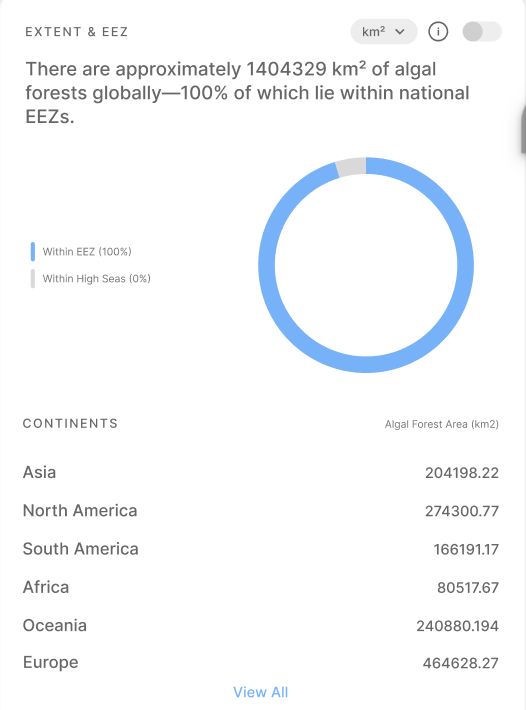

### Algal Forests (5 and 14)

This map was fully recreated as a GeoJSON dataset, with each kelp-forest region digitized into geographic coordinates. The threat icons shown on the image were converted into coded attributes representing warming, cooling, pollution, disease, herbivory, climate cycles, invasive species, overfishing, kelp harvest, heatwaves, cold spells, glacial run-off, and coastal development.

The top threats are included by region.

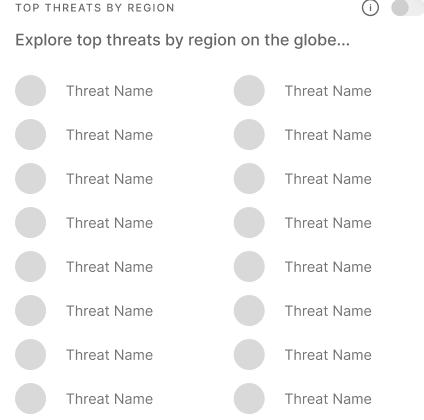

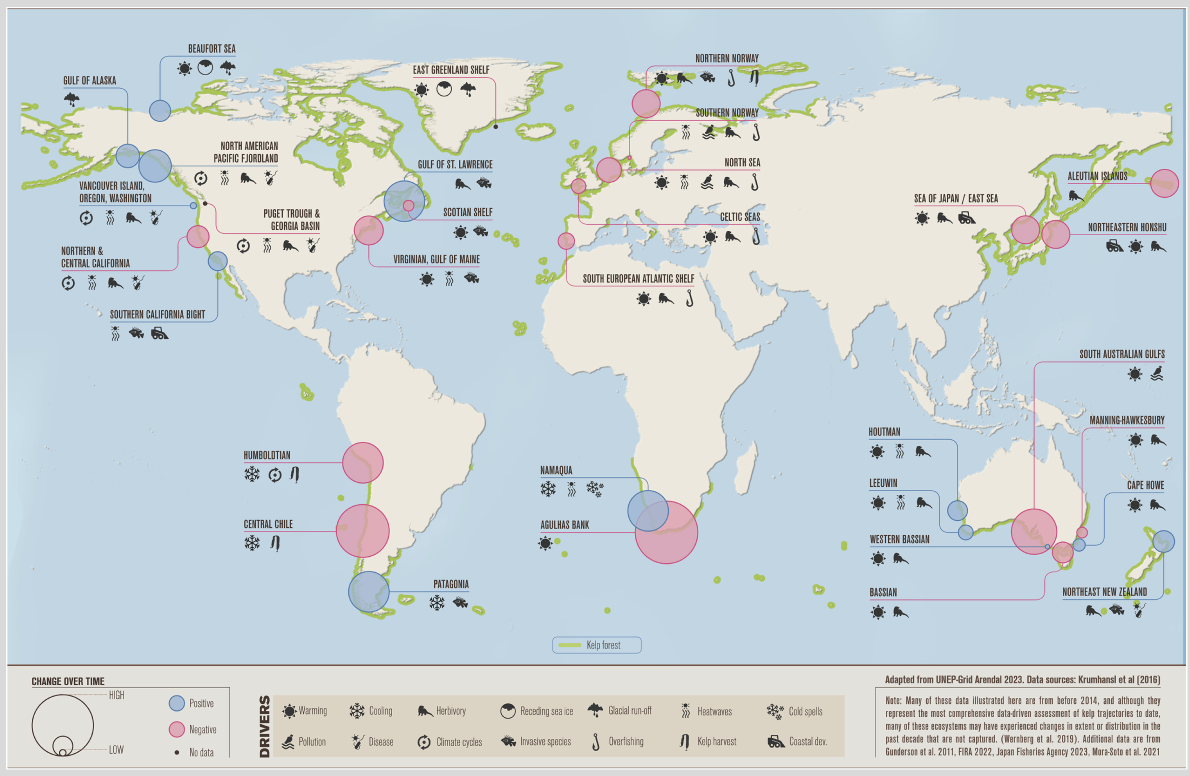

### Algal Forests (8 and 17)

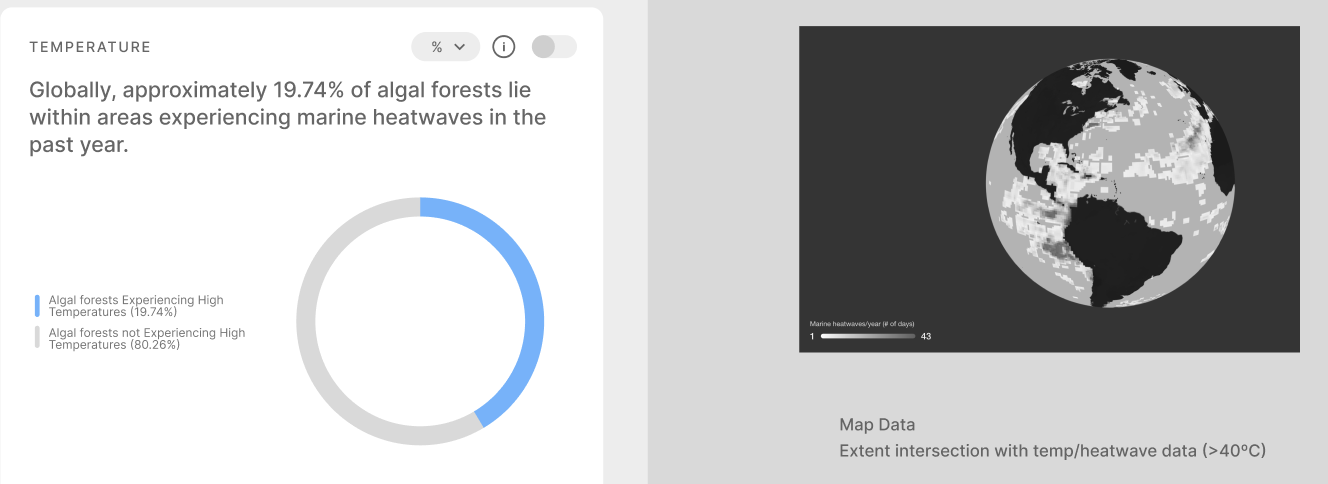

### Algal Forests (9 and 18)

This section uses the same *significant_acidification_trend.tif* generated in the Seagrass section to find significant trends in acidification

In [ ]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# -------------------------------------------------------------------
# INPUTS – update these
# -------------------------------------------------------------------
raster_path = "significant_acidification_trend.tif"
vector_path = "UniAuk-004-ModelledDistributionKelpBiome/01_Data/Kelp UNEP.shp"
vector_layer = None  # or layer name if needed

# -------------------------------------------------------------------
# 1. Read polygons
# -------------------------------------------------------------------
poly_gdf = gpd.read_file(vector_path, layer=vector_layer) if vector_layer else gpd.read_file(vector_path)

# -------------------------------------------------------------------
# 2. Build polygons from raster cells where raster > 0
# -------------------------------------------------------------------
with rasterio.open(raster_path) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata
    raster_crs = src.crs

    # mask = True where raster value > 0
    mask = data < 0
    if nodata is not None:
        mask &= (data != nodata)

    # Extract raster>0 regions as polygons
    raster_geoms = []
    for geom, val in shapes(data, mask=mask, transform=transform):
        raster_geoms.append(shape(geom))

# Merge all raster>0 polygons into one
raster_union = gpd.GeoSeries(raster_geoms, crs=raster_crs).unary_union
raster_union_gdf = gpd.GeoDataFrame(geometry=[raster_union], crs=raster_crs)

#raster_union_gdf.to_file("raster_gt0.gpkg", driver="GPKG")
# -------------------------------------------------------------------
# 3. Reproject polygons if needed
# -------------------------------------------------------------------
if poly_gdf.crs != raster_union_gdf.crs:
    poly_gdf = poly_gdf.to_crs(raster_union_gdf.crs)

# -------------------------------------------------------------------
# 4. Intersect polygons with raster>0 area
# -------------------------------------------------------------------
result = gpd.overlay(poly_gdf, raster_union_gdf, how="intersection")

print(result.head())

result.to_file("algal_forests_acidity.geojson", driver="GeoJSON")

# Use a Proj4 string for Mollweide (equal-area) to avoid EPSG db issues
moll_crs = "ESRI:54009"

# Reproject raster mask and vectors to Mollweide for area computation
raster_union_moll = raster_union_gdf.to_crs(moll_crs)
poly_moll = poly_gdf.to_crs(moll_crs)
result_reproj = result.to_crs(moll_crs)

# Compute total intersection area in Mollweide (m²)
if result_reproj.empty:
    result_area = 0.0
else:
    result_diss_moll = result_reproj.dissolve()
    result_area = result_diss_moll.geometry.area.iloc[0]

# Dissolve vectors into one polygon and compute area in Mollweide (m²)
vector_diss_moll = poly_moll.dissolve()
vector_area = vector_diss_moll.geometry.area.iloc[0]

percentage = (result_area / vector_area) * 100
print(f"Percentage of vector area over parent area: {percentage:.2f}%")

print(f"Result  area (>0) [Mollweide]: {result_area:,.2f} m²")
print(f"Total dissolved vector area [Mollweide]: {vector_area:,.2f} m²")

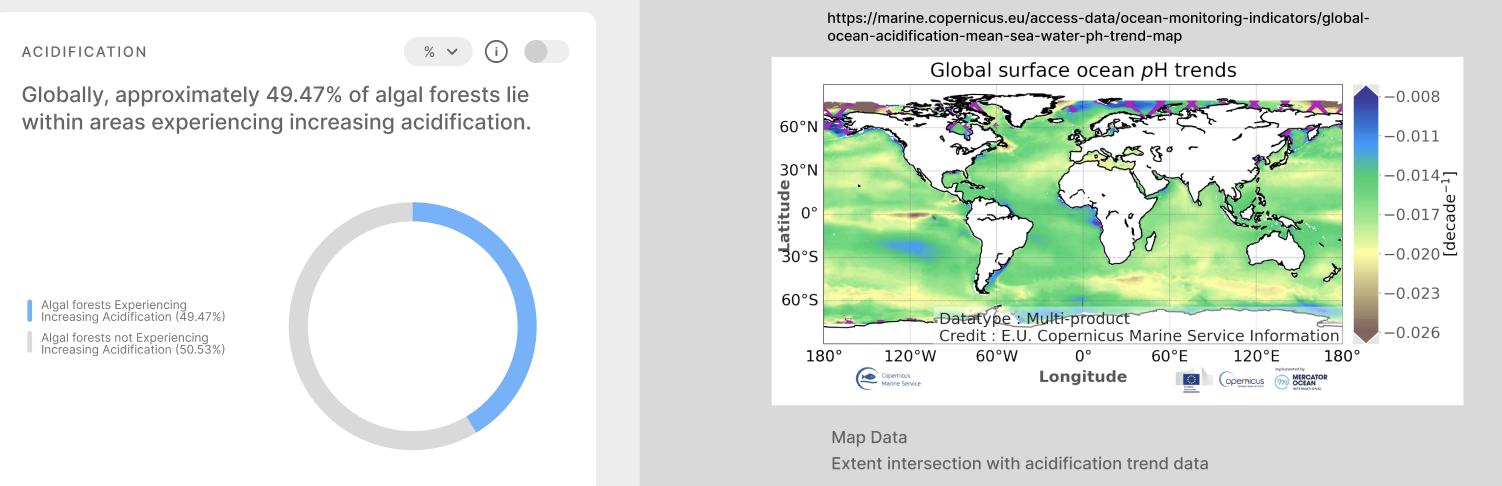

### Algal Forests (10 and 19)

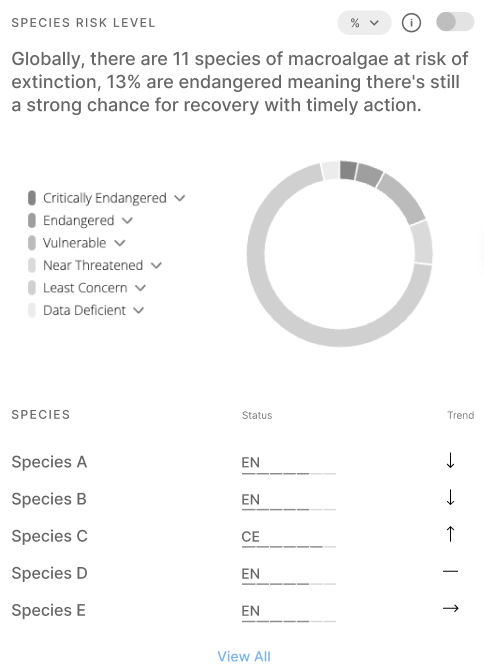

### Algal Forests (11 and 20)

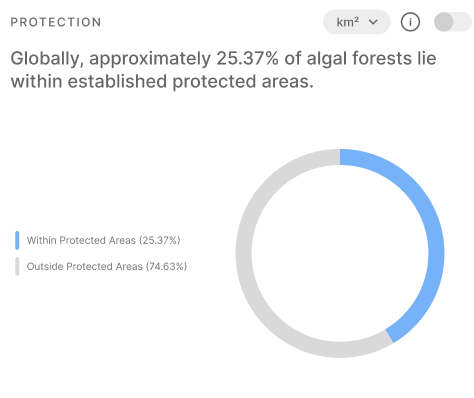

# Tidal Flats

### Tidal Flats (1)

In [ ]:
# Path to file
csv_file = "tidal_flats_timeseries.csv"

print(f"Processing {csv_file}...")

# Read CSV
df = pd.read_csv(csv_file, index_col=False)

# Remove unnamed column(s)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Rename column if present
if "Rescaled" in df.columns:
    df = df.rename(columns={"Rescaled": "Percent"})
else:
    print("Warning: 'Rescaled' column not found in mangroves_timeseries.csv")

# Convert to JSON records
data_json = df.to_dict(orient="records")

# Output JSON filename
json_file = "tidal_flats_timeseries.json"

# Save JSON
with open(json_file, "w", encoding="utf-8") as f:
    json.dump(data_json, f, indent=4)

print(f"✅ Saved {json_file}")

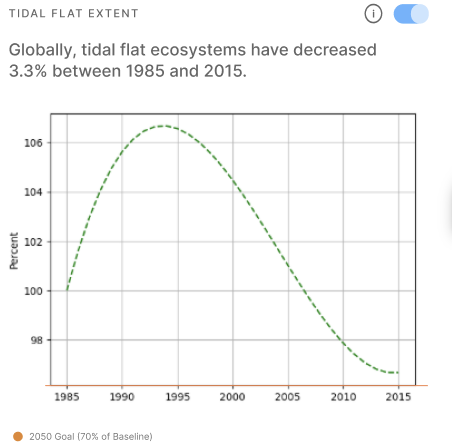

## Tidal Flats (2)

# Seamounts

### Seamounts Fig 1

Data for seamounts extent was downloaded from this website - https://data-gis.unep-wcmc.org/portal/home/item.html?id=4490b872250548a79e8c96da199be5f4

A total of 33,452 seamounts were identified, representing the largest global set of identified seamounts to date. 

In [ ]:
# GeoJSON conversion
# Input Shapefile path
shapefile_path = "SeamountsBaseArea.shp"

# Output GeoJSON path
geojson_path = "Fig_1_seamounts.geojson"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Reproject to WGS84 if needed for web maps
gdf = gdf.to_crs(epsg=4326)

# Write to GeoJSON
gdf.to_file(geojson_path, driver="GeoJSON")

print(f"Saved GeoJSON to {geojson_path}")

# Raster creation from vector using the predefined function in utils
vector_to_raster(
    vector_path='Seamounts.shp', #change paths accordingly
    out_raster_path='Fig_1_seamounts_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

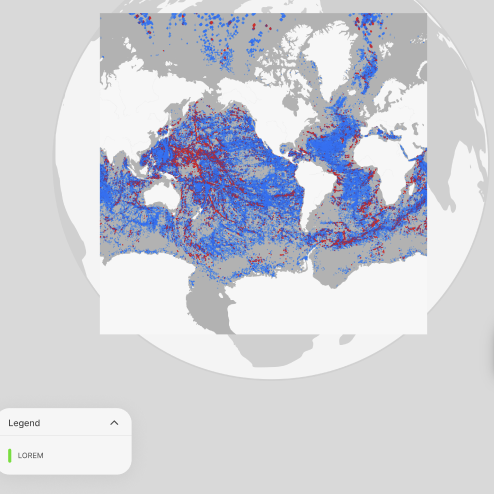

### Seamounts (2 and 6)

In [ ]:
# Same QGIS procedure as explained before

# The area is by marine regions, not countries

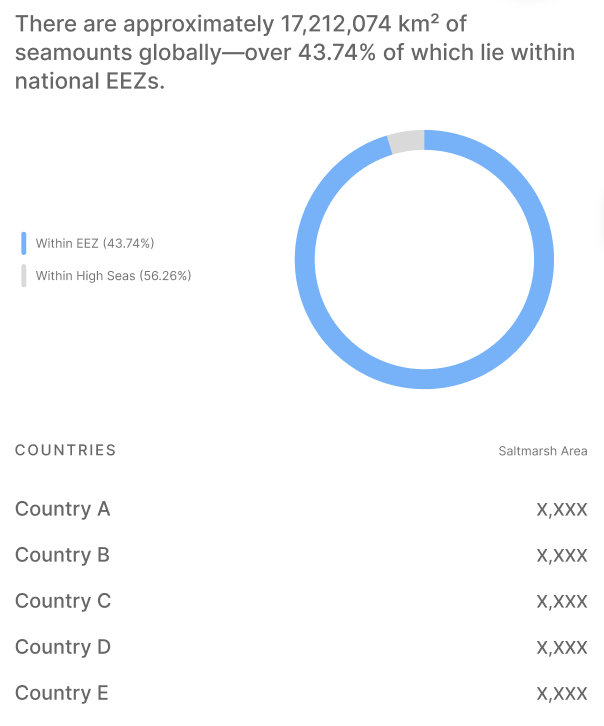

### Seamounts (4 and 8)

In [ ]:
import geopandas as gpd
from shapely.ops import unary_union

# First dissolve overlapping polygons to avoid duplication of area calculation
def dissolve_overlapping_polygons(input_path, output_path):
    """
    Dissolves overlapping polygons in a shapefile and saves the result.
    
    Parameters:
        input_path (str): Path to input shapefile (.shp)
        output_path (str): Path to output file (.shp or .gpkg)
    """
    # Load shapefile
    gdf = gpd.read_file(input_path)

    # Dissolve all geometries into one unary union (merges overlaps)
    dissolved_geom = unary_union(gdf.geometry)

    # Convert back to GeoDataFrame
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geom], crs=gdf.crs)

    # Save result
    dissolved_gdf.to_file(output_path)
    print(f"✅ Dissolved polygons saved to: {output_path}")

dissolve_overlapping_polygons("SeamountsBaseArea.shp", "dissolved_seamounts.gpkg")

# Once it is dissolved, the intersection is required with the merged WDPA MPA and OECMs file

QGIS SOLUTION

The Protected Areas and seamount extent was done using QGIS vector intersections due to large file sizes. Here are the steps:
1. Merge WDPA MPA and OECM layers into a single protected areas shapefile in QGIS.
3. Use Vector → Geoprocessing → Intersection to intersect the merged protected areas layer with the seamount vector layer.
4. Dissolve the intersection extent layer so it forms one unified polygon representing total habitat extent within protected areas.
5. Open the attribute table of the intersection output and create a new area field using the Field Calculator with the expression $area.
7. The resulting area values represent the protected seamounts area, which can then be summed or analyzed as needed.

The intersection area is then divided by the total seamounts vector area and the percentage is obtained and the intersection layer is exported as a geojson and geotiff for Fig 11.

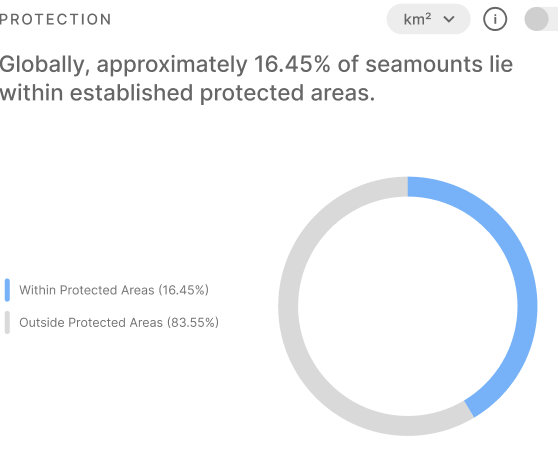

### Seamounts (5)

This number is obtained directly from this source - https://marine-conservation.org/on-the-tide/conserving-seamounts-on-a-global-scale/

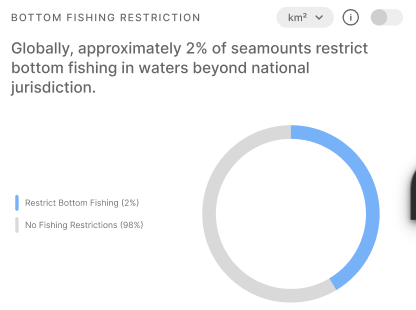